In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pickle
import json

from shapely import wkt

from joblib import Parallel, delayed
import multiprocessing

import scipy.stats as stats
from scipy.spatial import distance
from sklearn.preprocessing import OrdinalEncoder
from easydict import EasyDict as edict
from tqdm import tqdm

from scipy.stats import wasserstein_distance

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

import powerlaw

In [2]:
# import sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.utils import setup_seed, load_config

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.reset_orig()

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


In [4]:
def _apply_parallel(ls, func, n=-1, **kwargs):
    """parallel apply for spending up."""
    length = len(ls)
    cpunum = multiprocessing.cpu_count()
    if length < cpunum:
        spnum = length
    if n < 0:
        spnum = cpunum + n + 1
    else:
        spnum = n or 1

    return Parallel(n_jobs=n, verbose=0)(delayed(func)(seq, **kwargs) for seq in ls)

In [5]:
blues = sns.color_palette('Blues', 10)
blues

[(0.8978854286812764, 0.939038831218762, 0.977362552864283),
 (0.828881199538639, 0.8937639369473279, 0.954725105728566),
 (0.7506343713956171, 0.8478431372549019, 0.9282122260668974),
 (0.6325259515570935, 0.7976470588235294, 0.8868742791234141),
 (0.491764705882353, 0.7219684736639754, 0.8547789311803152),
 (0.36159938485198, 0.6427374086889658, 0.8165782391387928),
 (0.24816608996539793, 0.5618915801614763, 0.7709803921568628),
 (0.15072664359861593, 0.4644521337946943, 0.7207843137254902),
 (0.07481737793156479, 0.3732564398308343, 0.6552095347943099),
 (0.03137254901960784, 0.28161476355247983, 0.5582622068435218)]

In [6]:
# blues.as_hex(), print(blues.as_hex())
np.random.choice(blues.as_hex()[:-1], 4, replace=False), blues.as_hex()[-1]

(array(['#d3e4f3', '#e5eff9', '#3f8fc5', '#bfd8ed'], dtype='<U7'), '#08488e')

In [7]:
purples = sns.color_palette('Purples_d', 10)
purples

[(0.721763424323978, 0.7165961809560426, 0.8493399974368833),
 (0.6670562604126618, 0.6541073945918237, 0.8163270536972959),
 (0.6123490965013456, 0.5916186082276047, 0.7833141099577086),
 (0.5552633602460593, 0.5264129181084198, 0.7488658208381391),
 (0.500556196334743, 0.46392413174420094, 0.7158528770985518),
 (0.448560809944893, 0.4116929386133538, 0.6543073176983212),
 (0.39927720107650905, 0.3697193387158785, 0.5642291426374471),
 (0.3478508266051519, 0.325920799692426, 0.4702345251826221),
 (0.2985672177367679, 0.28394719979495064, 0.3801563501217481),
 (0.24928360886838397, 0.24197359989747533, 0.290078175060874)]

In [8]:
np.random.choice(purples.as_hex()[:-1], 4), purples.as_hex()[-1]

(array(['#7269a7', '#9c97c8', '#b8b7d9', '#665e90'], dtype='<U7'), '#403e4a')

In [9]:
greys = sns.color_palette('Greys', 10)
greys

[(0.9575547866205305, 0.9575547866205305, 0.9575547866205305),
 (0.9012072279892349, 0.9012072279892349, 0.9012072279892349),
 (0.8328950403690888, 0.8328950403690888, 0.8328950403690888),
 (0.7502191464821223, 0.7502191464821223, 0.7502191464821223),
 (0.6434140715109573, 0.6434140715109573, 0.6434140715109573),
 (0.5387158785082661, 0.5387158785082661, 0.5387158785082661),
 (0.440322952710496, 0.440322952710496, 0.440322952710496),
 (0.342883506343714, 0.342883506343714, 0.342883506343714),
 (0.22329873125720878, 0.22329873125720878, 0.22329873125720878),
 (0.10469819300269129, 0.10469819300269129, 0.10469819300269129)]

In [10]:
np.random.choice(greys.as_hex()[3:-1], 4, replace=False), greys.as_hex()[-1]

(array(['#393939', '#707070', '#898989', '#bfbfbf'], dtype='<U7'), '#1b1b1b')

# Duration and mode
## Reading

In [666]:
file_dir = [    
    # ".\\data\\validation\\na_layer6_14_200_1_200.json",

    # ".\\data\\validation\\na_layer6_linear_long_14_250_1_200.json",
    # ".\\data\\validation\\na_layer6_linear_long_run2_14_250_1_200.json",
    # ".\\data\\validation\\na_layer6_linear_14_200_1_200_seed101.json",
    # ".\\data\\validation\\na_layer6_linear_14_200_1_200_seed102.json", 
    # ".\\data\\validation\\na_layer6_linear_14_200_1_200_seed103.json", 

    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed101.json", 
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed102.json", 
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed103.json", 
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed104.json", 
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed105.json", 

    ".\\data\\validation\\na_layer6_linear_relu_smallLR_14_250_1_200.json", 
    
    
]

LENGTH = 50
MIN_PER_DAY = 60*24

pred_df_all = []
tgt_df = pd.DataFrame()

tgt = {
    "loc": [],
    "dur": [],
    "mode":[],
    "idx": [],
    "day": [],
    "day_min":[],
    "time":[],
}
src = {
    "loc":[],
    "dur":[],
    "mode":[],
    "idx":[],
    "day": [],
    "day_min":[],
    "time":[],
}

def get_unpadded_sequence(content, dataset="target"):
    locations = np.array(content[dataset])
    if dataset=="target":
        dur_seq = "tgt_dur"
        mode_seq = "tgt_mode"
        time_seq = "tgt_time"
    else:
        dur_seq = "src_dur"
        mode_seq = "src_mode"
        time_seq = "seq_time"
    # durations = (np.array(content[dur_seq]) + 1) / 2 * (MIN_PER_DAY * 2)
    durations = np.array(content[dur_seq])
    modes = np.array(content[mode_seq])
    times = np.array(content[time_seq])

    if dataset=="target":
        try:
            length = np.where(locations == 0)[0][0]
        except IndexError:
            length = len(locations)
        
        locations = locations[:length]
        durations = durations[:length]
        modes = modes[:length]
        times = times[:length]
        
        return locations, durations, modes, times
        # return locations, durations, modes
    else:
        try:
            length = np.where(locations == 0)[0][0]
            
            locations = locations[:length]
            durations = durations[:length]
            modes = modes[:length]
            times = times[:length]
        except IndexError:
            pass
        return locations, durations, modes, times
        # return locations, durations, modes
    
for i, file in enumerate(file_dir):
    predict = {
        "loc": [],
        "dur": [],
        "mode":[],
        "idx": [],
        "day": [],
        "day_min":[],
        "time":[],
    }
    with open(file, "r") as f_reader:
        for record_idx, row in enumerate(f_reader):
            content = json.loads(row)
            # src_locs, src_dur, src_mode = get_unpadded_sequence(content, dataset="source")
            src_locs, src_dur, src_mode, src_times = get_unpadded_sequence(content, dataset="source")
            
            start_time = np.array(content["seq_time"])[len(src_locs) - 1]

            if i == 0:
                src["idx"].extend(np.repeat(record_idx,len(src_locs)))
                src["loc"].extend(src_locs)
                src["dur"].extend(src_dur)
                src["mode"].extend(src_mode)
                src["time"].extend(src_times)
                
                abs_time = src["time"][0] + np.cumsum(src_dur)
                src["day"].extend((abs_time // MIN_PER_DAY).astype(int))
                src["day_min"].extend(abs_time % MIN_PER_DAY)
                
                tgt_locs, tgt_dur, tgt_mode, tgt_time = get_unpadded_sequence(content, dataset="target")
                # tgt_locs, tgt_dur, tgt_mode = get_unpadded_sequence(content, dataset="target")

                tgt["idx"].extend(np.repeat(record_idx,len(tgt_locs)))
                tgt["loc"].extend(tgt_locs)
                tgt["dur"].extend(tgt_dur)
                tgt["mode"].extend(tgt_mode)
                tgt["time"].extend(tgt_time)

                abs_time = start_time + np.cumsum(tgt_dur)
                tgt["day"].extend((abs_time // MIN_PER_DAY).astype(int))
                tgt["day_min"].extend(abs_time % MIN_PER_DAY)


            predict["idx"].extend(np.repeat(record_idx,LENGTH))
            predict["loc"].extend(np.array(content["recover"][:LENGTH]).squeeze())
            predict["mode"].extend(np.array(content["mode"][:LENGTH]).squeeze())
            predict["time"].extend(np.array(content["time"][:LENGTH]).squeeze())
            
            duration = np.array(content["duration"][:LENGTH]).squeeze()
            predict["dur"].extend(duration)
            
            abs_time = start_time + np.cumsum(duration)
            predict["day"].extend((abs_time // MIN_PER_DAY).astype(int))
            predict["day_min"].extend(abs_time % MIN_PER_DAY)

    if  i == 0:
        src_df = pd.DataFrame(src)
        tgt_df = pd.DataFrame(tgt)
    pred_df_all.append(pd.DataFrame(predict))

In [667]:
print(tgt_df["loc"].max(), src_df["loc"].max())
print([df["loc"].max() for df in pred_df_all])

28741 28741
[28735]


In [668]:
for df in pred_df_all:
    df.loc[df["loc"]>28741, "loc"] = 28741

# 14882 -> 14976 (28742 -> 28800)

In [669]:
diff_file_name = [name.split("\\")[-1].split(".")[0] for name in file_dir]
diff_file_name = ["Diffusion (Ours)"]
# diff_file_name = ["Base", "Base + xy + POI"]
diff_file_name 

['Diffusion (Ours)']

## Duration distribution

In [670]:
duration_df_all = []
for df in pred_df_all:
    new_df = df.copy()
    new_df.loc[new_df["dur"]<1, "dur"] = 1

    duration_df_all.append(new_df)

In [671]:
duration_df_all[0]["dur"].mean(), pred_df_all[0]["dur"].mean(), duration_df_all[0]["dur"].describe()

(380.2713732614705,
 380.2594624961406,
 count    1.814250e+06
 mean     3.802714e+02
 std      5.240135e+02
 min      1.000000e+00
 25%      5.336900e+01
 50%      1.451625e+02
 75%      5.390397e+02
 max      2.880000e+03
 Name: dur, dtype: float64)

In [672]:
tgt_df["dur_log"] = np.log(tgt_df["dur"]+1)
tgt_df["dur_log"].describe()

count    1.732822e+06
mean     4.904024e+00
std      1.438192e+00
min      0.000000e+00
25%      3.850148e+00
50%      4.882802e+00
75%      6.070738e+00
max      7.965893e+00
Name: dur_log, dtype: float64

In [673]:
def pdf(data, xmin=None, xmax=None, linear_bins=False, bins=None, **kwargs):
    """
    Returns the probability density function (normalized histogram) of the
    data.

    Parameters
    ----------
    data : list or array
    xmin : float, optional
        Minimum value of the PDF. If None, uses the smallest value in the data.
    xmax : float, optional
        Maximum value of the PDF. If None, uses the largest value in the data.
    linear_bins : float, optional
        Whether to use linearly spaced bins, as opposed to logarithmically
        spaced bins (recommended for log-log plots).

    Returns
    -------
    bin_edges : array
        The edges of the bins of the probability density function.
    probabilities : array
        The portion of the data that is within the bin. Length 1 less than
        bin_edges, as it corresponds to the spaces between them.
    """
    from numpy import logspace, histogram, floor, unique,asarray
    from math import ceil, log10
    data = asarray(data)
    if not xmax:
        xmax = max(data)
    if not xmin:
        xmin = min(data)

    if xmin<1:  #To compute the pdf also from the data below x=1, the data, xmax and xmin are rescaled dividing them by xmin.
        xmax2=xmax/xmin
        xmin2=1
    else:
        xmax2=xmax
        xmin2=xmin

    if bins is not None:
        bins = bins
    elif linear_bins:
        bins = range(int(xmin2), ceil(xmax2)+1)
    else:
        log_min_size = log10(xmin2)
        log_max_size = log10(xmax2)
        number_of_bins = ceil((log_max_size-log_min_size)*10)
        bins = logspace(log_min_size, log_max_size, num=number_of_bins)
        bins[:-1] = floor(bins[:-1])
        bins[-1] = ceil(bins[-1])
        bins = unique(bins)

    if xmin<1: #Needed to include also data x<1 in pdf.
        hist, edges = histogram(data/xmin, bins, density=True)
        edges=edges*xmin # transform result back to original
        hist=hist/xmin # rescale hist, so that np.sum(hist*edges)==1
    else:
        hist, edges = histogram(data, bins, density=True)

    return edges, hist

def trim_to_range(data, xmin=None, xmax=None, **kwargs):
    """
    Removes elements of the data that are above xmin or below xmax (if present)
    """
    from numpy import asarray
    data = asarray(data)
    if xmin:
        data = data[data>=xmin]
    if xmax:
        data = data[data<=xmax]
    return data
    
def cdf(data,
    xmin=None, xmax=None,
    survival=False, **kwargs):
    """
    The cumulative distribution function (CDF) of the data.

    Parameters
    ----------
    data : list or array, optional
    survival : bool, optional
        Whether to calculate a CDF (False) or CCDF (True). False by default.
    xmin : int or float, optional
        The minimum data size to include. Values less than xmin are excluded.
    xmax : int or float, optional
        The maximum data size to include. Values greater than xmin are
        excluded.

    Returns
    -------
    X : array
        The sorted, unique values in the data.
    probabilities : array
        The portion of the data that is less than or equal to X.
    """

    from numpy import array
    data = array(data)
    if not data.any():
        from numpy import nan
        return array([nan]), array([nan])

    data = trim_to_range(data, xmin=xmin, xmax=xmax)

    n = float(len(data))
    from numpy import sort
    data = sort(data)
    all_unique = not( any( data[:-1]==data[1:] ) )

    if all_unique:
        from numpy import arange
        CDF = arange(n)/n
    else:
#This clever bit is a way of using searchsorted to rapidly calculate the
#CDF of data with repeated values comes from Adam Ginsburg's plfit code,
#specifically https://github.com/keflavich/plfit/commit/453edc36e4eb35f35a34b6c792a6d8c7e848d3b5#plfit/plfit.py
        from numpy import searchsorted, unique
        CDF = searchsorted(data, data,side='left')/n
        unique_data, unique_indices = unique(data, return_index=True)
        data=unique_data
        CDF = CDF[unique_indices]

    if survival:
        CDF = 1-CDF
    return data, CDF

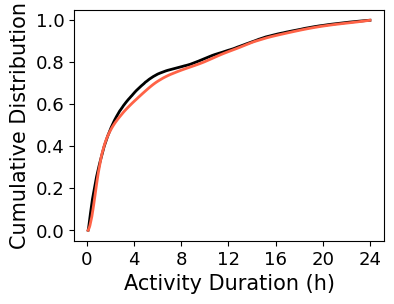

In [674]:
plt.figure(figsize=(4, 3))

bins, CDF = cdf((tgt_df["dur"]+1) / 60, xmin=0.1, xmax=24, survival=False)
plt.plot(bins, CDF, color="k", linewidth=2)

bins, CDF = cdf(duration_df_all[0]["dur"] / 60, xmin=0.1, xmax=24, survival=False)
plt.plot(bins, CDF, color="tomato", linewidth=2)

plt.xticks(np.arange(0, 25, 4))
plt.ylabel("Cumulative Distribution", fontsize=15)
plt.xlabel("Activity Duration (h)", fontsize=15)

plt.show()

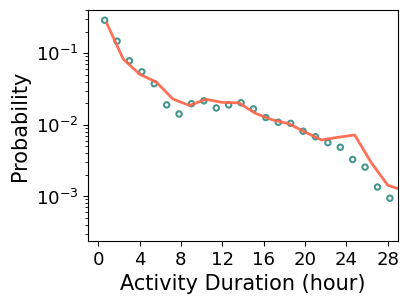

In [675]:
# na_layer6_linear_relu_14_250_1_200_seed102

plt.figure(figsize=(4, 3))


# edges, hist = pdf((tgt_df["dur"]+1) / 60, linear_bins=False)
# bin_centers = (edges[1:]+edges[:-1])/2.0
# hist[hist==0] = np.nan
# plt.plot(bin_centers, hist)

edges, hist = pdf((tgt_df["dur"]+1) / 60,  xmax=40, linear_bins=True, bins=40)
bin_centers = (edges[1:]+edges[:-1])/2.0
hist[hist==0] = np.nan
plt.scatter(bin_centers, hist, color=sns.color_palette("crest", 20)[7], 
            facecolors='none', s=15, linewidths=1.5, label="Data")

# edges, hist = pdf(duration_df_all[0]["dur"] / 60, linear_bins=False)
# bin_centers = (edges[1:]+edges[:-1])/2.0
# hist[hist==0] = np.nan
# plt.plot(bin_centers, hist)

for duration_df in duration_df_all:
    edges, hist = pdf(duration_df["dur"] / 60, xmax=24, linear_bins=True, bins=30)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    hist[hist==0] = np.nan
    plt.plot(bin_centers, hist, color="tomato", alpha=0.9, linewidth=2, label=diff_file_name[0])
    # plt.plot(bin_centers, hist, alpha=0.9, linewidth=2, label=diff_file_name[0])

plt.xlim([-1, 29])
# plt.ylim([10**(-3), plt.gca().get_ylim()[1]])
plt.xticks(np.arange(0, 30, 4))

# plt.xscale("log")
plt.yscale("log")
# plt.legend(prop={"size": 13})

plt.ylabel("Probability", fontsize=15)
plt.xlabel("Activity Duration (hour)", fontsize=15)

# plt.savefig(r'.\metrics\figures\p_duration.png', bbox_inches='tight', dpi=600)
plt.show()

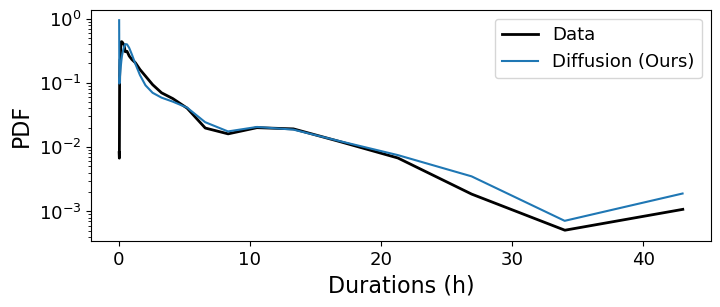

In [477]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

x = np.linspace(0, np.max(tgt_df["dur"]), 500)

# ax.plot(x, density(x), label="true")

powerlaw.plot_pdf((tgt_df["dur"]+1) / 60, linear_bins=False, label="Data", color="k", linewidth=2)

# powerlaw.plot_pdf((src_df.loc[src_df["dur"] != 0, "dur"].values +1)/ 60, label="Source", color="k", alpha=0.5, linewidth=2)
for curr_df, label in zip(duration_df_all, diff_file_name):
    powerlaw.plot_pdf(curr_df["dur"] /60, linear_bins=False, label=label)

plt.xscale("linear")
# plt.yscale("linear")

# plt.ylim(10**-12, 10**-2)
# plt.xlim(10**-1, 2880)

plt.legend(prop={"size": 13})
plt.xlabel("Durations (h)", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'.\metrics\figures\duration.png', bbox_inches='tight', dpi=600)
plt.show()



In [478]:
print(wasserstein_distance(tgt_df["dur"]/60, src_df["dur"]/60))

for duration_df in duration_df_all:
    print(wasserstein_distance(tgt_df["dur"]/60, duration_df["dur"]/60))

0.5774858189661252
0.8076010738410031


## Mode distribution

In [676]:
['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

In [677]:
unique, counts = np.unique(tgt_df["mode"], return_counts=True)
print(unique)
print(counts/counts.sum() * 100)

_, counts = np.unique(src_df["mode"], return_counts=True)
print(counts/counts.sum() * 100)

[1 2 3 4 5 6 7]
[ 6.3223  4.4523 43.0755  0.1214  8.5339  1.5537 35.941 ]
[ 7.1085  4.3518 43.7059  0.1358  7.2782  1.4057 36.014 ]


In [678]:
for pred_df, label in zip(pred_df_all, diff_file_name):
    curr_arr = np.array(pred_df["mode"])
    unique, counts = np.unique(curr_arr, return_counts=True)
    print(label)
    print(unique)
    print(counts/counts.sum() * 100)

Diffusion (Ours)
[1 2 3 4 5 6 7]
[ 7.5999  3.9612 44.7343  0.1694  7.0695  1.4934 34.9722]


### Individual distribution

In [503]:
def get_mode_dist(df):
    unique, counts  = np.unique(df, return_counts=True)
    df = pd.DataFrame({'labels': unique, 'values': counts/counts.sum() * 100})
    return df
def get_dist(df):
    density = stats.gaussian_kde(df["values"])
    return density

In [504]:
tgt_mode_df = tgt_df.groupby("idx")["mode"].apply(get_mode_dist).reset_index().drop(columns="level_1")
tgt_kdes = tgt_mode_df.groupby("labels").apply(get_dist).to_list()

C:\Users\hong\AppData\Local\Temp\ipykernel_37476\721863790.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tgt_kdes = tgt_mode_df.groupby("labels").apply(get_dist).to_list()


In [505]:
pred_mode_df = pred_df_all[0].groupby("idx")["mode"].apply(get_mode_dist).reset_index().drop(columns="level_1")
pred_kdes = pred_mode_df.groupby("labels").apply(get_dist).to_list()

C:\Users\hong\AppData\Local\Temp\ipykernel_37476\644479120.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_kdes = pred_mode_df.groupby("labels").apply(get_dist).to_list()


In [506]:
tgt_mode_df["type"] = "Data"
pred_mode_df["type"] = "Diffusion (Ours)"
mode_df = pd.concat([tgt_mode_df, pred_mode_df])

In [301]:
mode_df.type.value_counts()

type
Data                133165
Diffusion (Ours)    124174
Name: count, dtype: int64

<Figure size 400x600 with 0 Axes>

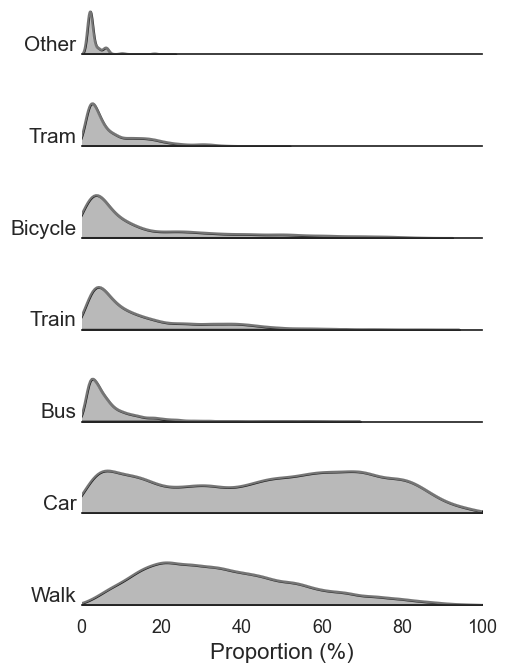

In [302]:
# Initialize the FacetGrid object
ordered_modes = tgt_mode_df.labels.value_counts().index[::-1]
ordered_type = ["Data", "Diffusion (ours)"]

# Set up the figure
plt.figure(figsize=(4, 6))

# Sort the occupations for better visualization
mode = ['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

# Plotting
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette(["k", "tomato"])

g = sns.FacetGrid(mode_df, row="labels", hue="type", aspect=5, height=1, sharey=False,
                  palette=pal, row_order=ordered_modes, hue_order=ordered_type)
g.map(sns.kdeplot, "values", fill=True, alpha=0.3, linewidth=2)
g.map(sns.kdeplot, "values", fill=False, alpha=0.4, linewidth=2, color="white")
# pal = sns.color_palette(["b"])

# g.map(plt.axhline, y=0, lw=1, clip_on=False)

# # Set axis labels and titles
g.set_xlabels("Proportion (%)", fontsize=16)

# Customize the y-ticks and remove them
for i, ax in enumerate(g.axes.flat):
    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_ylabel(mode[ordered_modes[i]-1], fontsize=15, labelpad=4, y=0,
                  rotation=0, rotation_mode="anchor", va='bottom', ha="right")
    
g.despine(bottom=False, left=True)

# # Adjust the space between the plots
# g.fig.subplots_adjust(hspace=-.25)

plt.tick_params(axis='both', which='major', labelsize=13)
# Add a legend
g.set_titles("")


# plt.savefig(r'.\metrics\figures\mode_distribution.png', bbox_inches='tight', dpi=600)

plt.show()


In [507]:
mode_map = {1:'Bicycle', 2:'Bus', 3:'Car', 4:'Other', 5:'Train', 6:'Tram', 7:'Walk'}

mode_df["labels"] = mode_df["labels"].map(mode_map)

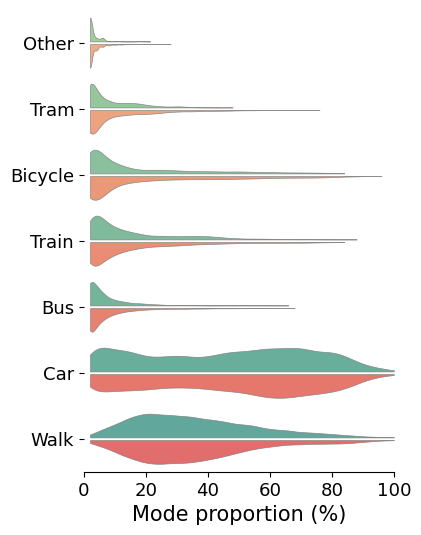

In [511]:
# na_layer6_linear_relu_14_250_1_200_seed103

from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection, LineCollection

plt.figure(figsize=(4, 6))


red_colors = sns.color_palette("flare", 20)
grey_colors = sns.color_palette("crest", 20)
pal = sns.color_palette([grey_colors[7], "tomato"])

order_hue = ["Data", "Diffusion (Ours)"]
order = mode_df["labels"].value_counts().index


ax = sns.violinplot(data=mode_df, x="values", y="labels", hue="type", split=True, 
                    order=order[::-1], hue_order=order_hue, gap=.1, cut=0,
                    linewidth=0.5, palette=pal, linecolor="grey", 
                    inner=None, density_norm='width')


for ind, violin in enumerate(ax.findobj(PolyCollection)):
    rgb = to_rgb(grey_colors[ind//2])
    if ind % 2 != 0:
        rgb = to_rgb(red_colors[ind//2])
        # rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    violin.set_alpha(0.9)

ax.yaxis.set_tick_params(labelsize = 13)
ax.xaxis.set_tick_params(labelsize = 13)
plt.xlabel("Mode proportion (%)", fontsize=15)
plt.ylabel("")
plt.xlim(0, 100)
# plt.legend(prop={"size": 12}, frameon=False, 
#            bbox_to_anchor=(-0.5, -0.2), loc="upper left", ncol=2)
ax.get_legend().remove()

sns.despine(bottom = False, left = True)
plt.savefig(r'.\metrics\figures\mode_distribution.png', bbox_inches='tight', dpi=600)

plt.show()

### Divergence

In [679]:
_, true_counts = np.unique(tgt_df["mode"], return_counts=True)
true_counts = true_counts/true_counts.sum()

_, src_counts = np.unique(src_df["mode"], return_counts=True)
src_counts = src_counts/src_counts.sum()
print(distance.jensenshannon(src_counts, true_counts))

for pred_df, label in zip(pred_df_all, diff_file_name):
    print(label)
    _, pred_counts = np.unique(pred_df["mode"], return_counts=True)

    try: 
        print(distance.jensenshannon(pred_counts[1:]/pred_counts.sum(), true_counts))
    except ValueError:
        print(distance.jensenshannon(pred_counts/pred_counts.sum(), true_counts))

0.019992347669414528
Diffusion (Ours)
0.02904501476283515


In [680]:
# na_layer6_linear_relu_14_250_1_200_seed103

print(wasserstein_distance(tgt_df["mode"], src_df["mode"])) 

for pred_df, label in zip(pred_df_all, diff_file_name):
    print(label)
    print(wasserstein_distance(tgt_df["mode"], pred_df["mode"]))



0.04266711436448904
Diffusion (Ours)
0.09000674657032529


### Pie plot

In [306]:
labels = ['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

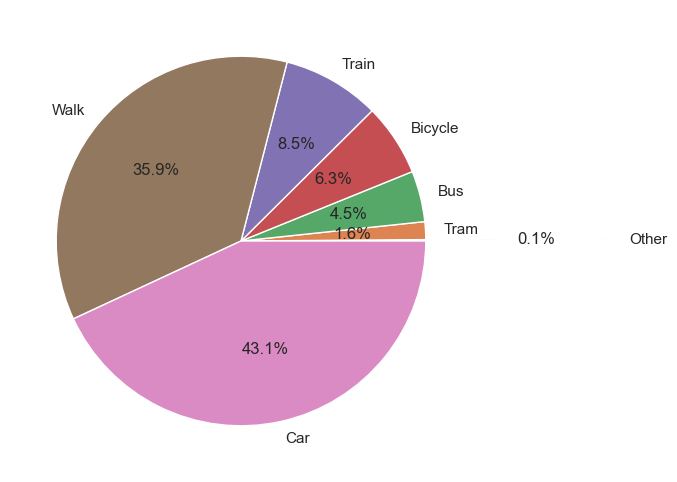

In [307]:
unique, counts = np.unique(tgt_df["mode"], return_counts=True)
data = {'labels': labels, 'values': counts/counts.sum() * 100}
df = pd.DataFrame(data)
df.sort_values(by="values", inplace=True)

# sns.set_style("whitegrid") # Set style for chart

plt.figure(figsize=(6,6)) # Set figure size

explode = np.zeros(len(df))
explode[0] = 1
plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%', explode=explode) # Create pie chart



plt.show() # Show chart

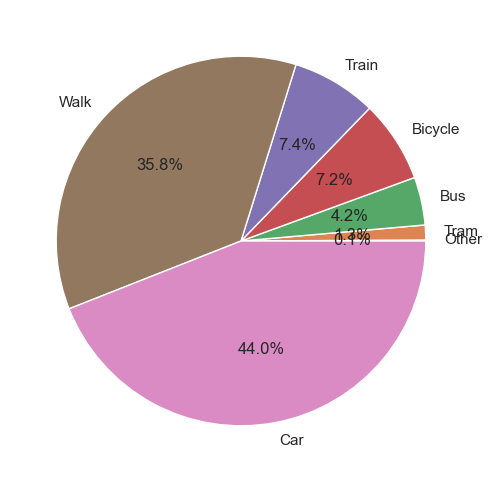

In [308]:
unique, counts = np.unique(pred_df["mode"], return_counts=True)
data = {'labels': labels, 'values': counts/counts.sum() * 100}
df = pd.DataFrame(data)
df.sort_values(by="values", inplace=True)

# sns.set_style("whitegrid") # Set style for chart

plt.figure(figsize=(6,6)) # Set figure size

plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%') # Create pie chart



plt.show() # Show chart

## Jump legth by mode

In [681]:
all_locs = pd.read_csv(os.path.join("data", "s2_loc_visited_level10_14.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
    all_locs["loc_id"].values.reshape(-1, 1)
)
all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

In [682]:
def get_jump_idx(df):
    geo_x = df["geometry"].x.values
    geo_y = df["geometry"].y.values
    jump = np.array([np.sqrt((geo_x[i] - geo_x[i - 1])**2 + (geo_y[i] - geo_y[i - 1])**2) for i in range(1, len(df))])
    
    df["jump"] = np.insert(jump, 0, 0, axis=0)
    return df

def get_jump(df):
    df = df.copy()
    df = df.merge(all_locs, left_on="loc", right_on="loc_id")
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:2056")
    return gdf.groupby("idx").apply(get_jump_idx).reset_index(drop=True)

In [683]:
tgt_jump = get_jump(tgt_df)

C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4115136093.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return gdf.groupby("idx").apply(get_jump_idx).reset_index(drop=True)


In [684]:
pred_jump_ls = [get_jump(pred_df) for pred_df in pred_df_all]

C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4115136093.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return gdf.groupby("idx").apply(get_jump_idx).reset_index(drop=True)


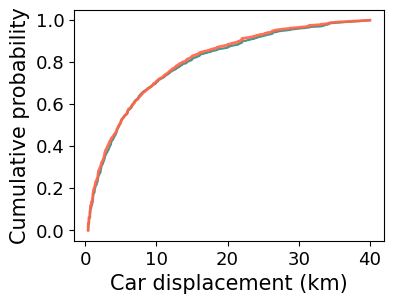

In [685]:
# na_layer6_linear_relu_14_250_1_200_seed103
# car = 3

true_jp = tgt_jump.loc[tgt_jump["mode"]==3, "jump"].values
true_jp = true_jp[true_jp>1]

# plotting
plt.figure(figsize=(4, 3))

bins, CDF = cdf(true_jp /1000, xmin=0.1, xmax=40, survival=False)
plt.plot(bins, CDF, color=sns.color_palette("crest", 20)[7], linewidth=1.5, label="Data")

for pred_jump in pred_jump_ls:
    pred_jp = pred_jump.loc[pred_jump["mode"]==3, "jump"].values
    pred_jp = pred_jp[pred_jp>1]

    bins, CDF = cdf(pred_jp /1000, xmin=0.1, xmax=40, survival=False)
    plt.plot(bins, CDF, color="tomato", linewidth=2,  alpha=0.9, label="Diffusion")
    # plt.plot(bins, CDF, linewidth=2,  alpha=0.9, label="Diffusion")

plt.xlabel("Car displacement (km)", fontsize=15)
plt.ylabel("Cumulative probability", fontsize=15)

# plt.savefig(r'.\metrics\figures\jump_car.png', bbox_inches='tight', dpi=600)

plt.show()

In [686]:
true_jp_data = trim_to_range((true_jp /1000), xmin=0.1, xmax=40)

for pred_jump in pred_jump_ls:
    pred_jp = pred_jump.loc[pred_jump["mode"]==3, "jump"].values
    pred_jp = pred_jp[pred_jp>1]
    pred_jp_data = trim_to_range((pred_jp /1000), xmin=0.1, xmax=40)
    
    print(stats.ks_2samp(true_jp_data, pred_jp_data))

KstestResult(statistic=0.02618748672691218, pvalue=1.006373053197143e-181, statistic_location=3.2226304750225956, statistic_sign=-1)


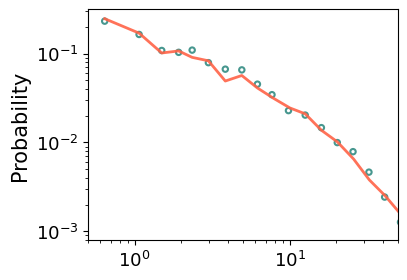

In [687]:
# car = 3

true_jp = tgt_jump.loc[tgt_jump["mode"]==3, "jump"].values
true_jp = true_jp[true_jp>1]

pred_jp = pred_jump.loc[pred_jump["mode"]==3, "jump"].values
pred_jp = pred_jp[pred_jp>1]

# plotting
plt.figure(figsize=(4, 3))

edges, hist = pdf(true_jp/1000, linear_bins=False)
bin_centers = (edges[1:]+edges[:-1])/2.0
hist[hist==0] = np.nan
plt.scatter(bin_centers, hist, color=sns.color_palette("crest", 20)[7], 
            linewidth=1.5, s=15, facecolors='none',label="Data")

powerlaw.plot_pdf(pred_jp/1000, color="tomato", linewidth=2,  alpha=0.9, label="Diffusion")

# plt.xscale("linear")
plt.ylabel("Probability", fontsize=15)

plt.xlim([0.5, 50])
plt.ylim([10**(-3.1), 10**(-0.5)])
# plt.savefig(r'.\metrics\figures\jump_car_p.png', bbox_inches='tight', dpi=600)

plt.show()

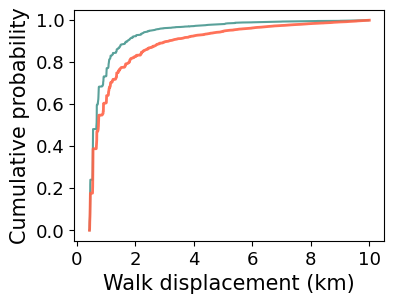

In [688]:
true_jp = tgt_jump.loc[tgt_jump["mode"]==7, "jump"].values
true_jp = true_jp[true_jp>1]

pred_jp = pred_jump.loc[pred_jump["mode"]==7, "jump"].values
pred_jp = pred_jp[pred_jp>1]

# plotting
plt.figure(figsize=(4, 3))

bins, CDF = cdf(true_jp /1000, xmin=0.1, xmax=10, survival=False)
plt.plot(bins, CDF, color=sns.color_palette("crest", 20)[7], linewidth=1.5, alpha=0.9, label="Data")

bins, CDF = cdf(pred_jp /1000, xmin=0.1, xmax=10, survival=False)
plt.plot(bins, CDF, color="tomato", linewidth=2,  alpha=0.9, label="Diffusion")

plt.xlabel("Walk displacement (km)", fontsize=15)
plt.ylabel("Cumulative probability", fontsize=15)

plt.xlim([-0.1, 10.5])
plt.xticks(np.arange(0, 11, 2))


# plt.savefig(r'.\metrics\figures\jump_walk.png', bbox_inches='tight', dpi=600)

plt.show()

In [689]:
true_jp = tgt_jump.loc[tgt_jump["mode"]==7, "jump"].values
true_jp = true_jp[true_jp>1]

true_jp_data = trim_to_range((true_jp /1000), xmin=0.1, xmax=40)

for pred_jump in pred_jump_ls:
    pred_jp = pred_jump.loc[pred_jump["mode"]==7, "jump"].values
    pred_jp = pred_jp[pred_jp>1]
    pred_jp_data = trim_to_range((pred_jp /1000), xmin=0.1, xmax=40)
    
    print(stats.ks_2samp(true_jp_data, pred_jp_data))

KstestResult(statistic=0.18573679453894554, pvalue=0.0, statistic_location=1.116016383155731, statistic_sign=1)


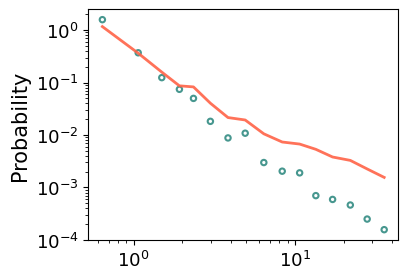

In [690]:
true_jp = tgt_jump.loc[tgt_jump["mode"]==7, "jump"].values
true_jp = true_jp[true_jp>1]

pred_jp = pred_jump.loc[pred_jump["mode"]==7, "jump"].values
pred_jp = pred_jp[pred_jp>1]

plt.figure(figsize=(4, 3))

# plotting
edges, hist = pdf(true_jp/1000, xmax=40, linear_bins=False)
bin_centers = (edges[1:]+edges[:-1])/2.0
hist[hist==0] = np.nan
plt.scatter(bin_centers, hist, color=sns.color_palette("crest", 20)[7], 
            linewidth=1.5,  s=15, facecolors='none', label="Data")

edges, hist = pdf(pred_jp/1000, xmax=40, linear_bins=False)
bin_centers = (edges[1:]+edges[:-1])/2.0
hist[hist==0] = np.nan
plt.plot(bin_centers, hist, color="tomato", linewidth=2, alpha=0.9, label="Diffusion")

plt.ylabel("Probability", fontsize=15)

# plt.xlim([-0.1, 10])
plt.yscale("log")
plt.xscale("log")

# plt.savefig(r'.\metrics\figures\jump_walk_p.png', bbox_inches='tight', dpi=600)

plt.show()

## Location per day

In [691]:
def get_day_unique_locs(df):
    _, counts = np.unique(df.groupby(["idx", "day"])["loc"].nunique(), return_counts=True)
    return counts/counts.sum()

tgt_unique_counts = get_day_unique_locs(tgt_df)
pred_unique_counts_ls = [get_day_unique_locs(df) for df in pred_df_all]

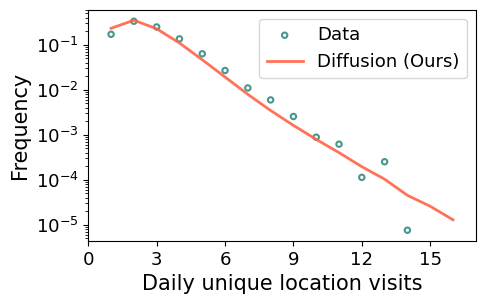

In [692]:
# na_layer6_linear_relu_14_250_1_200_seed102

plt.figure(figsize=(5, 3))

# plotting
# plt.plot(np.arange(len(tgt_unique_counts)) + 1, tgt_unique_counts, color="k", linewidth=2, label="True")

plt.scatter(np.arange(len(tgt_unique_counts)) + 1, tgt_unique_counts, 
            color=sns.color_palette("crest", 20)[7], facecolors='none', 
            s=15, linewidths=1.5,label="Data")

for pred_unique_counts, label in zip(pred_unique_counts_ls, diff_file_name):
    # plt.plot(np.arange(len(pred_unique_counts)) + 1, pred_unique_counts, label=label)
    plt.plot(np.arange(len(pred_unique_counts[:-4])) + 1, pred_unique_counts[:-4], color="tomato", 
             alpha=0.9, linewidth=2, label=label)

# plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.xlabel("Daily unique location visits", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(np.arange(0, 19, 3))
plt.xlim([0, 17])

# plt.savefig(r'.\metrics\figures\unique_lk.png', bbox_inches='tight', dpi=600)
plt.show()

In [693]:
tgt_loc_day = tgt_df.groupby(["idx", "day"])["loc"].nunique()
src_loc_day = src_df.groupby(["idx", "day"])["loc"].nunique()

print(wasserstein_distance(tgt_loc_day, src_loc_day))

for pred_df in pred_df_all:
    pred_loc_day = pred_df.groupby(["idx", "day"])["loc"].nunique()
    print(wasserstein_distance(tgt_loc_day, pred_loc_day))

0.2861613887928367
0.2547040127406548


In [694]:
def get_day_locs(df):
    _, counts = np.unique(df.groupby(["idx", "day"])["loc"].count(), return_counts=True)
    return counts/counts.sum()

tgt_counts = get_day_locs(tgt_df)
pred_counts_ls = [get_day_locs(df) for df in pred_df_all]

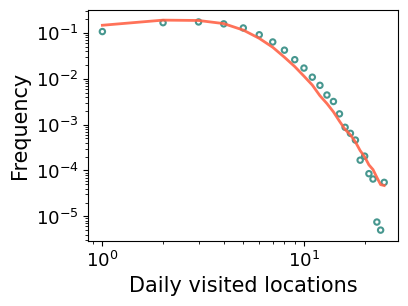

In [695]:
# na_layer6_linear_relu_14_250_1_200_seed102

plt.figure(figsize=(4, 3))

# plotting
plt.scatter(np.arange(len(tgt_counts)) + 1, tgt_counts, 
            color=sns.color_palette("crest", 20)[7], facecolors='none', 
            s=15, linewidths=1.5,label="True")

for pred_counts, label in zip(pred_counts_ls, diff_file_name):
    plt.plot(np.arange(len(pred_counts[:-10])) + 1, pred_counts[:-10], color="tomato", 
             alpha=0.9, linewidth=2, label=label)
    # plt.plot(np.arange(len(pred_counts[:-5])) + 1, pred_counts[:-5], 
    #          alpha=0.9, linewidth=2, label=label)

plt.xscale("log")
plt.yscale("log")
# plt.legend(prop={"size": 13})

plt.xlabel("Daily visited locations", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

# plt.savefig(r'.\metrics\figures\daily_lk.png', bbox_inches='tight', dpi=600)
plt.show()

In [487]:
tgt_loc_day = tgt_df.groupby(["idx", "day"])["loc"].count()
src_loc_day = src_df.groupby(["idx", "day"])["loc"].count()

print(wasserstein_distance(tgt_loc_day, src_loc_day))

for pred_df in pred_df_all:
    pred_loc_day = pred_df.groupby(["idx", "day"])["loc"].count()
    print(wasserstein_distance(tgt_loc_day, pred_loc_day))

0.6558193877863773
0.39837878698183793


In [352]:
tgt_df.groupby(["idx", "day"])["loc"].count()

idx    day
0      0       1
       1       2
       2       4
       3       4
       4       2
              ..
36284  3      13
       4       7
       5       9
       6       7
       7       2
Name: loc, Length: 400034, dtype: int64

## Active time during day

In [696]:
src_df["min_bin_15"] = src_df["day_min"] // 15
tgt_df["min_bin_15"] = tgt_df["day_min"] // 15

pred_active_all = []
for pred_df in pred_df_all:
    pred_df["min_bin_15"] = pred_df["day_min"] // 15
    pred_active_all.append(pred_df)


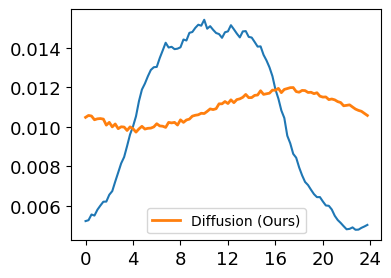

In [697]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

active = tgt_df.groupby("min_bin_15").size().values
plt.plot(np.arange(len(active))/4, active/active.sum())

for pred_df, label in zip(pred_active_all, diff_file_name):
    active_pred = pred_df.groupby("min_bin_15").size().values
    plt.plot(np.arange(len(active_pred))/4, active_pred/active.sum(), linewidth=2, label=label)

plt.xticks(np.arange(0, 25, 4))
plt.legend()
plt.show()

In [698]:
tgt_df["min_bin_15"] = tgt_df["time"] // 15
src_df["min_bin_15"] = src_df["time"] // 15

pred_active_all = []
for pred_df in pred_df_all:
    pred_df["min_bin_15"] = pred_df["time"] // 15
    pred_active_all.append(pred_df)

In [699]:
np.histogram(pred_df["time"], bins=20)

(array([  8100,   4377,  15022,  64588, 113980, 100913, 101746, 111795,
        129030, 158069, 121002, 140495, 150978, 161255, 132876,  95174,
         67842,  54475,  47088,  35445], dtype=int64),
 array([   0.,   72.,  144.,  216.,  288.,  360.,  432.,  504.,  576.,
         648.,  720.,  792.,  864.,  936., 1008., 1080., 1152., 1224.,
        1296., 1368., 1440.]))

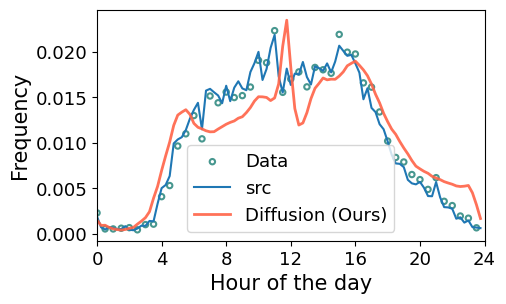

In [700]:
# na_layer6_linear_long_14_250_1_200

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

active = tgt_df.groupby("min_bin_15").size().values
# plt.plot(np.arange(len(active))/4, active/active.sum(), label = "Data")

plt.scatter((np.arange(len(active))/4)[::2], (active/active.sum())[::2], 
            color=sns.color_palette("crest", 20)[7], facecolors='none', 
            s=15, linewidths=1.5,label="Data")

active_src = src_df.groupby("min_bin_15").size()
plt.plot(np.arange(len(active_src))/4, active_src/active_src.sum(), label="src")

for pred_df, label in zip(pred_active_all, diff_file_name):
    active_pred = pred_df.groupby("min_bin_15").size().values[:-1]
    plt.plot(np.arange(len(active_pred))/4, active_pred/active_pred.sum(), color="tomato", alpha=0.9, linewidth=2, label=label)
    # plt.plot(np.arange(len(active_pred))/4, active_pred/active.sum(), alpha=0.9, linewidth=2, label=label)

plt.xticks(np.arange(0, 25, 4))

plt.xlabel("Hour of the day", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

plt.legend(prop={"size": 13})
plt.xlim([0, 24])
# plt.savefig(r'.\metrics\figures\active_hours.png', bbox_inches='tight', dpi=600)
plt.show()

In [701]:
len(active), len(active_src), len(active_pred)

(96, 96, 96)

In [702]:
wasserstein_distance(u_values=np.arange(len(active)), 
                     v_values=np.arange(len(active_src)), 
                     u_weights=active, 
                     v_weights=active_src)

1.1126503466032402

In [703]:
wasserstein_distance(u_values=np.arange(len(active)), 
                     v_values=np.arange(len(active_pred)), 
                     u_weights=active, 
                     v_weights=active_pred)

2.2550932319281594

## Motifs

In [361]:
import networkx as nx
from networkx.algorithms import isomorphism


def _construct_graph(df):
    G = nx.DiGraph()
    G.add_nodes_from(df["loc"])

    G.add_edges_from(df.iloc[:-1][["loc", "next_loc"]].astype(int).values)

    in_degree = np.all([False if degree == 0 else True for _, degree in G.in_degree])
    out_degree = np.all([False if degree == 0 else True for _, degree in G.out_degree])
    if in_degree and out_degree:
        return G


def get_graphs(df_valid):
    graphs_ls = []
    for uniq_visits in tqdm(range(1, 7)):
        curr_df = df_valid.loc[df_valid["uniq_visits"] == uniq_visits].copy()
        curr_df["next_loc"] = curr_df["loc"].shift(-1)
    
        if uniq_visits == 1:
            graph_s = curr_df.groupby(["idx", "day"]).size().rename("class").reset_index()
            graph_s["class"] = 0
            graph_s["uniq_visits"] = uniq_visits
            
            graphs_ls.append(graph_s)
            # daily_records.append(len(curr_graph))
            continue
    
        # the edge number shall be at least the node number
        curr_edge_num = curr_df.groupby(["idx", "day"]).size() - 1
        valid_user_days = curr_edge_num[curr_edge_num >= uniq_visits].rename("edge_num")
        curr_df = curr_df.merge(valid_user_days.reset_index(), on=["idx", "day"], how="left")
        curr_df = curr_df.loc[~curr_df["edge_num"].isna()]
    
        if uniq_visits == 2:
            graph_s = curr_df.groupby(["idx", "day"]).size().rename("class").reset_index()
            graph_s["class"] = 0
            graph_s["uniq_visits"] = uniq_visits
        
            graphs_ls.append(graph_s)
            continue
    
        graph_df = curr_df.groupby(["idx", "day"]).apply(_construct_graph, include_groups=False)
        if len(graph_df) == 0:
            continue
        # filter graphs that do not have an in-degree and out degree
        graph_df = graph_df.loc[~graph_df.isna()]
        graphs = graph_df.values
    
        motifs_groups = []
        for i in range(graphs.shape[0] - 1):
            if i in [item for sublist in motifs_groups for item in sublist]:
                continue
            possible_match = [i]
            for j in range(i + 1, graphs.shape[0]):
                if isomorphism.GraphMatcher(graphs[i], graphs[j]).is_isomorphic():
                    possible_match.append(j)
            motifs_groups.append(possible_match)
        # print(len(graphs))
        # print(len([item for sublist in motifs_groups for item in sublist]))
    
        graph_df = graph_df.rename("graphs").reset_index()
        class_arr = np.zeros(len(graph_df))
        for i, classes in enumerate(motifs_groups):
            class_arr[classes] = i
        graph_df["class"] = class_arr
        graph_df["class"] = graph_df["class"].astype(int)
        graph_df["uniq_visits"] = uniq_visits

        # graph_df.drop(columns={"graphs"}, inplace=True)
    
        graphs_ls.append(graph_df)
    return pd.concat(graphs_ls)


            
# def _label_classes(graphs_ls):
#     total_motifs = np.sum([len(num) for num in graphs_ls])

#     all_user_days = []
#     for i, graph in enumerate(graphs_ls):
#         if i == 0 or i == 1:
#             res = graph.drop(columns={"size"})
#             res["class"] = i * 10
#             all_user_days.append(res)
#         else:
#             prop = graph["class"].value_counts() / total_motifs * 100
#             valid_class = prop[prop > 0.5].index
#             res = graph.loc[graph["class"].isin(valid_class)].copy()
#             res = res.drop(columns={"graphs"})
#             res["class"] = i * 10 + res["class"]
#             all_user_days.append(res)

#     return pd.concat(all_user_days)
    
def get_motifs(df, proportion_filter=0.005):
    df = df.copy()

    # delete the self transitions
    df["loc_next"] = df["loc"].shift(-1)
    df["day_next"] = df["day"].shift(-1)
    df = df.loc[~((df["loc_next"] == df["loc"]) & (df["day_next"] == df["day"]))].copy()
    df.drop(columns=["loc_next", "day_next"], inplace=True)

    user_days = df.groupby(["idx", "day"]).agg({"loc": "nunique"})
    value_counts = user_days.value_counts()

    # the fraction of daily location visit <= 6 locations
    print(value_counts.head(6).sum() / value_counts.sum())
    
    # the mean daily location visit
    print(user_days.mean().values[0])

    # only select daily location visit < 7 records
    valid_user_days = user_days[user_days<7]
    valid_user_days.rename(columns={"loc": "uniq_visits"}, inplace=True)
    valid_user_days = valid_user_days.dropna()
    valid_user_days = valid_user_days.astype(int)

    df_valid = df.merge(valid_user_days.reset_index(), on=["idx", "day"], how="left")
    df_valid = df_valid.loc[~df_valid["uniq_visits"].isna()]
    
    # check daily location visit filter is correct
    # print(df_valid.groupby(["idx", "day"]).agg({"loc": "nunique"}).value_counts())
    # print(df_valid)

    graphs_ls = get_graphs(df_valid)

    total_graphs = len(graphs_ls)
    def _get_valid_motifs(df):
        if (len(df) / total_graphs) > proportion_filter:
            return df

    # get the valid motifs per user days
    motifs_user_days = (
        graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)
    )
    # merge back to all user days
    return_df = (
        df_valid.groupby(["idx", "day"])
        .size()
        .rename("visits")
        .reset_index()
        .merge(motifs_user_days, on=["idx", "day"], how="left")
    )

    return return_df, total_graphs

In [362]:
src_df

,loc,dur,mode,idx,day,day_min,time
0,9423,241.0,3,0,0,609.0,368.0
1,9423,1190.0,7,0,1,359.0,609.0
2,9423,573.0,7,0,1,932.0,359.0
3,9428,36.0,3,0,1,968.0,932.0
4,9423,1123.0,3,0,2,651.0,968.0
...,...,...,...,...,...,...,...
3562840,17172,51.0,3,36284,20,559.0,453.0
3562841,17172,371.0,3,36284,20,930.0,504.0
3562842,17172,895.0,3,36284,21,385.0,875.0
3562843,20600,41.0,3,36284,21,426.0,330.0


In [210]:
src_motifs, src_motifs_length = get_motifs(src_df)

0.9615806728876719
3.055423501513255


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:20<00:00, 33.35s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [211]:
tgt_motifs, tgt_motifs_length = get_motifs(tgt_df)

0.9787293080088193
2.7692621127204187


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:20<00:00, 13.36s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [418]:
pred_motifs_ls = []
pred_motifs_length_ls = []

for pred_df in pred_df_all:
    pred_motifs,pred_motifs_length = get_motifs(pred_df, proportion_filter=0.001)
    pred_motifs_ls.append(pred_motifs)
    pred_motifs_length_ls.append(pred_motifs_length)

0.9869613727784838
2.474782619637846


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.51s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


0.9852140701482811
2.490230235339026


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:20<00:00, 13.50s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


0.986823003908431
2.4166327670096512


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:09<00:00, 11.59s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


0.9867310662907135
2.4202015519057105


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


0.9867152966837178
2.4206682898865677


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.30s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\4060361480.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [419]:
def _get_motifs_proportion(df):
    return (len(df["class"]) - df["class"].isna().sum()) / len(df["class"])

print("Mobility motifs proportion across users:")
print(f"True: {_get_motifs_proportion(tgt_motifs):.3f}")
print(f"Source: {_get_motifs_proportion(src_motifs):.3f}")

for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    print(label + f": {_get_motifs_proportion(pred_motifs):.3f}")

Mobility motifs proportion across users:
True: 0.345
Source: 0.328
na_layer6_linear_long_14_250_1_200: 0.418
na_layer6_linear_long_run2_14_250_1_200: 0.420
na_layer6_linear_14_200_1_200_seed101: 0.424
na_layer6_linear_14_200_1_200_seed102: 0.424
na_layer6_linear_14_200_1_200_seed103: 0.423


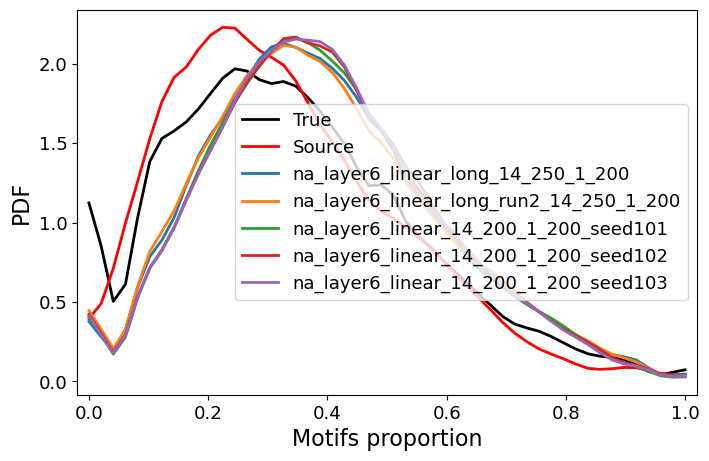

In [408]:
# plot the user distribution of all motifs
plt.figure(figsize=(8, 5))

# plotting
x = np.linspace(0, 1, 50)

# get the user density
user_motifs_proportion = tgt_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
Density = stats.gaussian_kde(user_motifs_proportion)
plt.plot(x, Density(x), color="k", linewidth=2, label="True")

user_motifs_proportion = src_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
Density = stats.gaussian_kde(user_motifs_proportion)
plt.plot(x, Density(x), color="red", linewidth=2, label="Source")

for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    user_motifs_proportion = pred_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
    Density = stats.gaussian_kde(user_motifs_proportion)
    plt.plot(x, Density(x), linewidth=2, label=label)

plt.xlim([-0.02, 1.02])
plt.xlabel("Motifs proportion", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.legend(prop={"size": 13})
plt.show()

In [420]:
def get_motifs_frq(df, df_motif_length):
    # get the proportion of each motif type for y-axis
    motifs_frq = (
        df.rename(columns={"size": "uniq_visits"}).dropna(subset="class").groupby(["uniq_visits", "class"], as_index=False).size().reset_index(drop=True)
    )
    motifs_frq["size"] = motifs_frq["size"] / df_motif_length
    # create unique labels for x-axis
    motifs_frq["label"] = (
        motifs_frq["uniq_visits"].astype(int).astype(str) + "_" + motifs_frq["class"].astype(int).astype(str)
    )
    return motifs_frq
tgt_motifs_frq = get_motifs_frq(tgt_motifs, tgt_motifs_length)


pred_motifs_frq_ls = [get_motifs_frq(pred_motifs, pred_motifs_length) for pred_motifs, pred_motifs_length in zip(pred_motifs_ls, pred_motifs_length_ls)]

In [421]:
# na_layer6_linear_long_14_250_1_200

tgt_motif_f = tgt_motifs.dropna(subset="class").groupby(["uniq_visits", "class"]).size().sort_values(ascending=False)
src_motif_f = src_motifs.dropna(subset="class").groupby(["uniq_visits", "class"]).size().sort_values(ascending=False)


wd_ts = wasserstein_distance(u_values=np.arange(len(tgt_motif_f)), 
                     v_values=np.arange(len(src_motif_f)), 
                     u_weights=tgt_motif_f, 
                     v_weights=src_motif_f)

print(wd_ts)
for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    pred_motif_f = pred_motifs.dropna(subset="class").groupby(["uniq_visits", "class"]).size().sort_values(ascending=False)
    
    wd_tp = wasserstein_distance(u_values=np.arange(len(tgt_motif_f)), 
                         v_values=np.arange(len(pred_motif_f)), 
                         u_weights=tgt_motif_f, 
                         v_weights=pred_motif_f)
    print(wd_tp)

0.32924167921091724
0.2960761732960421
0.30490914873722086
0.3493925284732481
0.3383090911170785
0.335995689132895


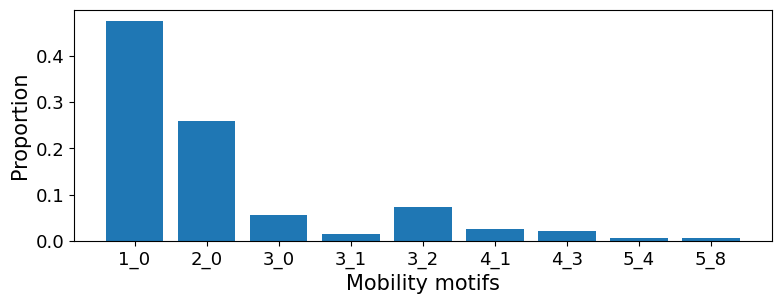

In [422]:
# plot the motifs distribution for all user days
plt.figure(figsize=(9, 3))

# plotting
x = np.arange(len(tgt_motifs_frq["label"]))
plt.bar(x=x, height=tgt_motifs_frq["size"], tick_label=tgt_motifs_frq["label"])
plt.xlabel("Mobility motifs", fontsize=15)
plt.ylabel("Proportion", fontsize=15)
# plt.savefig(r'.\metrics\figures\motifs.png', bbox_inches='tight', dpi=600)
plt.show()

In [423]:
tgt_lookup = tgt_motifs.groupby(["uniq_visits", "class"], as_index=False).head(1).sort_values(by="uniq_visits")
tgt_lookup

,idx,day,visits,class,uniq_visits,graphs
0,0,0,1,0.0,1.0,NaN
5,0,5,3,0.0,2.0,NaN
7,0,7,5,0.0,3.0,"(9423, 9420, 9419)"
70,4,11,5,1.0,3.0,"(9697, 9423, 9654)"
333,29,10,4,2.0,3.0,"(17179, 17180, 17100)"
3294,268,2,6,1.0,4.0,"(20459, 17161, 20431, 20525)"
3770,308,7,6,3.0,4.0,"(20431, 20459, 17161, 20310)"
5493,514,5,6,4.0,5.0,"(17106, 24502, 17161, 17170, 17174)"
7555,727,9,7,8.0,5.0,"(17106, 17174, 17161, 26334, 25595)"


nodes: 3.0, category: 0.0


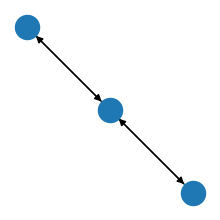

nodes: 3.0, category: 1.0


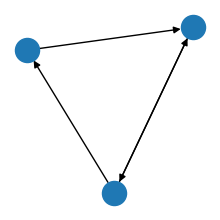

nodes: 3.0, category: 2.0


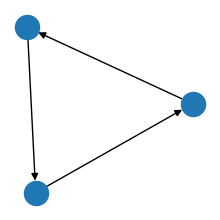

nodes: 4.0, category: 1.0


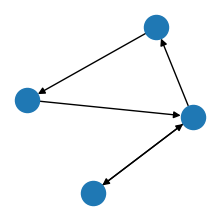

nodes: 4.0, category: 3.0


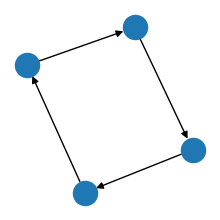

nodes: 5.0, category: 4.0


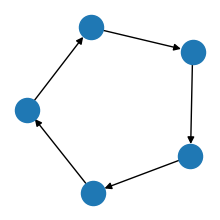

nodes: 5.0, category: 8.0


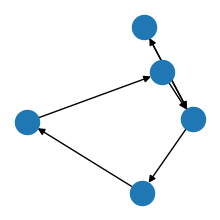

In [372]:
for i in range(len(tgt_lookup)):
    if i<2:
        continue    
    print(f"nodes: {tgt_lookup.iloc[i].uniq_visits}, category: {tgt_lookup.iloc[i]['class']}")
    plt.figure(figsize=(2, 2))
    nx.draw(tgt_lookup.iloc[i]["graphs"])
    plt.show()

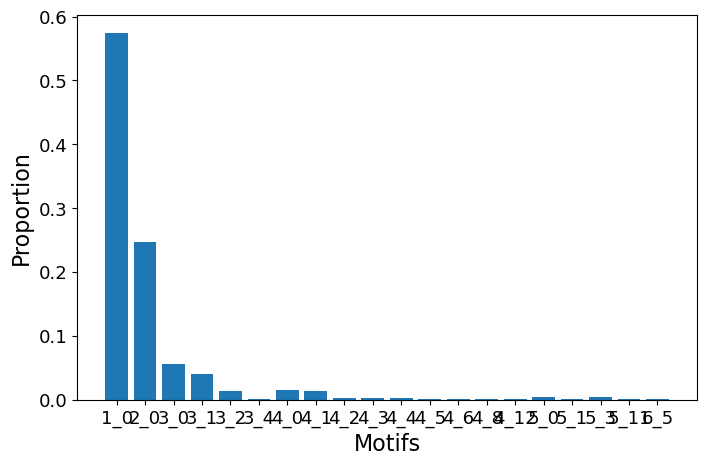

In [426]:
# na_layer6_linear_long_14_250_1_200

# plot the motifs distribution for all user days
plt.figure(figsize=(8, 5))

dataset = pred_motifs_frq_ls[0]
# plotting
x = np.arange(len(dataset["label"]))
plt.bar(x=x, height=dataset["size"], tick_label=dataset["label"])
plt.xlabel("Motifs", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
# plt.savefig(os.path.join(log_dir, "Mean motifs distribution.png"), bbox_inches="tight", dpi=600)
plt.show()

In [431]:
pred_lookup = pred_motifs_ls[0].groupby(["uniq_visits", "class"], as_index=False).head(1).sort_values(by="uniq_visits")
pred_lookup

,idx,day,visits,class,uniq_visits,graphs
0,0,0,1,0.0,1.0,NaN
2,0,2,3,0.0,2.0,NaN
7,0,8,4,0.0,3.0,"(9423, 9396, 9587)"
104,6,1,5,1.0,3.0,"(9423, 9396, 9398)"
5056,322,10,6,4.0,3.0,"(17106, 17175, 17154)"
2103,119,1,5,2.0,3.0,"(4733, 5317, 5352)"
5790,389,1,6,8.0,4.0,"(17106, 17174, 17177, 23873)"
5213,337,3,7,6.0,4.0,"(17106, 17174, 17101, 17176)"
4757,302,7,7,5.0,4.0,"(17161, 20456, 20431, 20459)"
3859,236,0,8,4.0,4.0,"(20431, 20459, 23830, 20404)"


In [453]:
for i in range(len(tgt_lookup)):
    if i<2:
        continue

    visits = tgt_lookup.iloc[i]["uniq_visits"]

    potential_match = pred_lookup.loc[pred_lookup["uniq_visits"] == visits]
    match = False
    for _, row in potential_match.iterrows():
        if isomorphism.GraphMatcher(tgt_lookup.iloc[i]["graphs"], row["graphs"]).is_isomorphic():
            match = True
            print_str = f"{int(tgt_lookup.iloc[i]['uniq_visits'])}_{int(tgt_lookup.iloc[i]['class'])}: is matched with {int(row['uniq_visits'])}_{int(row['class'])}"
            print(print_str)
            continue
    if not match:
        print(f"{tgt_lookup.iloc[i]['uniq_visits']}, class {tgt_lookup.iloc[i]['class']} cannot be matched.")

3_0: is matched with 3_1
3_1: is matched with 3_2
3_2: is matched with 3_0
4_1: is matched with 4_0
4_3: is matched with 4_1
5_4: is matched with 5_0
5_8: is matched with 5_3


In [455]:
tgt_motifs_frq["order"] = np.arange(len(tgt_motifs_frq)) + 1
selected_dataset = dataset.drop(index=[5, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19]).reset_index(drop=True)
selected_dataset["order"] = np.array([0, 1, 4, 2, 3, 6, 5, 7, 8]) + 1


tgt_motifs_frq, selected_dataset.sort_values(by="order")

(   uniq_visits  class      size label  order  type
 0          1.0    0.0  0.476088   1_0      1  Data
 1          2.0    0.0  0.259993   2_0      2  Data
 2          3.0    0.0  0.056545   3_0      3  Data
 3          3.0    1.0  0.014978   3_1      4  Data
 4          3.0    2.0  0.073674   3_2      5  Data
 5          4.0    1.0  0.024730   4_1      6  Data
 6          4.0    3.0  0.021639   4_3      7  Data
 7          5.0    4.0  0.006584   5_4      8  Data
 8          5.0    8.0  0.006842   5_8      9  Data,
    uniq_visits  class      size label  order
 0          1.0    0.0  0.574156   1_0      1
 1          2.0    0.0  0.246763   2_0      2
 3          3.0    1.0  0.039577   3_1      3
 4          3.0    2.0  0.012881   3_2      4
 2          3.0    0.0  0.055991   3_0      5
 6          4.0    1.0  0.014295   4_1      6
 5          4.0    0.0  0.014590   4_0      7
 7          5.0    0.0  0.003742   5_0      8
 8          5.0    3.0  0.003677   5_3      9)

In [456]:
tgt_motifs_frq["type"] = "Data"
selected_dataset["type"] = "Diffusion"

motifs_frq = pd.concat([tgt_motifs_frq, selected_dataset])
motifs_frq["size"] = motifs_frq["size"]*100

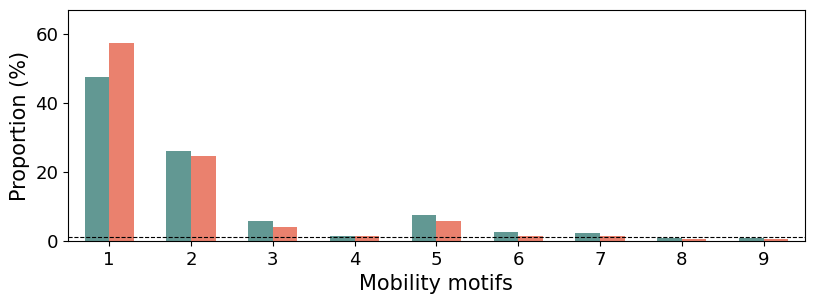

In [461]:
# plot the motifs distribution for all user days
plt.figure(figsize=(9.5, 3))

red_colors = sns.color_palette("flare", 20)
grey_colors = sns.color_palette("crest", 20)
pal = sns.color_palette([grey_colors[7], "tomato"])
order_hue = ["Data", "Diffusion"]

ax = sns.barplot(motifs_frq, x="order", y="size", hue="type", hue_order=order_hue, 
                 width=0.6, alpha=0.9, palette=pal)

ax.axhline(1, ls='--',linewidth=0.8, alpha=1, color="k")

plt.ylim([0, 67])

# plt.yscale("log")
plt.xlabel("Mobility motifs", fontsize=15)
plt.ylabel("Proportion (%)", fontsize=15)

ax.get_legend().remove()
# ax.get_xaxis().set_ticks([])

plt.savefig(r'.\metrics\figures\motifs.png', bbox_inches='tight', dpi=600)

plt.show()

## Trip packages

In [376]:
def applyParallel(dfGrouped, func):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(func)(group) for _, group in dfGrouped
    )
    return pd.concat(retLst)

### Unique locations

In [377]:
def _get_loc_evolution_idx(df):
    evolution = np.zeros(len(df))

    for i in range(len(df)):
        evolution[i] = len(set(df.iloc[:i]["loc"]))

    result = pd.DataFrame({"evolution": evolution, "idx": df["idx"].index[0]})
    result["step"] = np.arange(len(result))
    return result

def get_loc_evolution(df):
    loc_evolution = applyParallel(df.groupby("idx"), _get_loc_evolution_idx)
    groupby_evolution = loc_evolution.groupby("step")["evolution"]
    return groupby_evolution.mean(), groupby_evolution.size()




In [215]:
tgt_mean, tgt_size = get_loc_evolution(tgt_df)

In [216]:
pre_mean, pre_size = get_loc_evolution(pred_df_all[0])

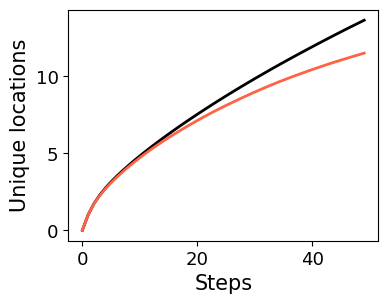

In [217]:
# plot the motifs distribution for all user days
plt.figure(figsize=(4, 3))

x = tgt_mean.index.values
plt.plot(x, tgt_mean, color="k", linewidth=2, label="True")
plt.plot(x, pre_mean, color="tomato", linewidth=2, label=diff_file_name)

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Steps", fontsize=15)
plt.ylabel("Unique locations", fontsize=15)


plt.show()

In [218]:
def _get_loc_evolution_idx_time(df, max_time=693):
    evolution = np.zeros(int(max_time+1))
    loc = df["loc"].values
    for i in range(len(df)):
        evolution[int(df.iloc[i]["1h_bin"])] = len(set(loc[:i]))

    evolution_df = pd.DataFrame(evolution)
    evolution_df.replace(0, np.nan, inplace=True)
    evolution = evolution_df.ffill().replace(np.nan, 0).values
    return np.concatenate(evolution)

def get_loc_evolution_time(df):
    df = df.copy()
    df["total_min"] = df["day"]*60*24 + df["day_min"]
    df["1h_bin"] = df["total_min"]//60

    tqdm.pandas(desc="get_loc_evolution_time")
    hour = df.groupby("idx").progress_apply(_get_loc_evolution_idx_time, max_time=df["1h_bin"].max())
    
    return np.vstack(hour.values).mean(axis=0)

In [219]:
tgt_mean_time = get_loc_evolution_time(tgt_df)

get_loc_evolution_time: 100%|███████████████████████████████████████████████████| 36285/36285 [01:44<00:00, 345.72it/s]


In [220]:
pre_mean_time = get_loc_evolution_time(pred_df_all[0])

get_loc_evolution_time: 100%|███████████████████████████████████████████████████| 36285/36285 [01:57<00:00, 308.75it/s]


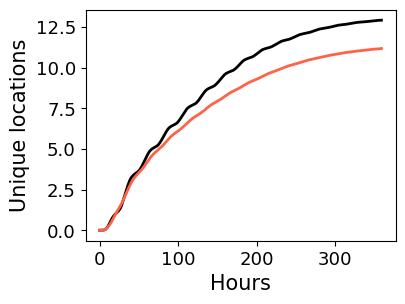

In [221]:
# plot the motifs distribution for all user days
plt.figure(figsize=(4, 3))

plt.plot(np.arange(len(tgt_mean_time[:360])), tgt_mean_time[:360], color="k", linewidth=2, label="True")
plt.plot(np.arange(len(pre_mean_time[:360])), pre_mean_time[:360], color="tomato", linewidth=2, label=diff_file_name)

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Hours", fontsize=15)
plt.ylabel("Unique locations", fontsize=15)

plt.show()

### Construct

In [600]:
def construct_tp(df):
    df["tp"] = df.groupby(["loc", "mode"]).ngroup()
    
    return df

In [601]:
tgt_tp_df = applyParallel(tgt_df.groupby("idx", as_index=False), construct_tp)

In [602]:
pred_tp_df_ls = [applyParallel(pred_df.groupby("idx", as_index=False), construct_tp) for pred_df in pred_df_all]

### Unique trip packages

In [603]:
def _get_tp_evolution_idx(df):
    evolution = np.zeros(len(df))

    for i in range(len(df)):
        evolution[i] = len(set(df.iloc[:i]["tp"]))

    result = pd.DataFrame({"evolution": evolution, "idx": df["idx"].index[0]})
    result["step"] = np.arange(len(result))
    return result
    
def _get_tp_evolution(df):
    tp_evolution = applyParallel(df.groupby("idx"), _get_tp_evolution_idx)
    groupby_evolution = tp_evolution.groupby("step")["evolution"]
    return groupby_evolution.mean(), groupby_evolution.size()

In [604]:
tgt_tp_evolution, tgt_size = _get_tp_evolution(tgt_tp_df)

In [605]:
pred_tp_evolution, pred_size = _get_tp_evolution(pred_tp_df)

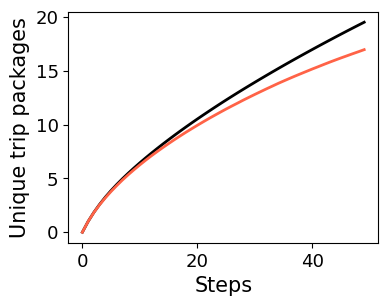

In [228]:
# plot the motifs distribution for all user days
plt.figure(figsize=(4, 3))

x = tgt_mean.index.values
plt.plot(x, tgt_tp_evolution, color="k", linewidth=2, label="True")
plt.plot(x, pred_tp_evolution, color="tomato", linewidth=2, label=diff_file_name)

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Steps", fontsize=15)
plt.ylabel("Unique trip packages", fontsize=15)

plt.show()

In [606]:
def _get_tp_evolution_idx_time(df, max_time=693):
    evolution = np.zeros(int(max_time+1))
    tp = df["tp"].values
    for i in range(len(df)):
        evolution[int(df.iloc[i]["1h_bin"])] = len(set(tp[:i]))

    evolution_df = pd.DataFrame(evolution)
    evolution_df.replace(0, np.nan, inplace=True)
    evolution = evolution_df.ffill().replace(np.nan, 0).values
    return np.concatenate(evolution)

def get_tp_evolution_time(df):
    df = df.copy()
    df["total_min"] = df["day"]*60*24 + df["day_min"]
    df["1h_bin"] = df["total_min"]//60

    tqdm.pandas(desc="get_tp_evolution_time")
    hour = df.groupby("idx").progress_apply(_get_tp_evolution_idx_time, max_time=df["1h_bin"].max())
    
    return np.vstack(hour.values).mean(axis=0)

In [607]:
tgt_tp_time = get_tp_evolution_time(tgt_tp_df)

get_tp_evolution_time: 100%|████████████████████████████████████████████████████| 36285/36285 [01:49<00:00, 330.58it/s]


In [608]:
pre_tp_time_ls = [get_tp_evolution_time(pred_tp_df) for pred_tp_df in pred_tp_df_ls]

get_tp_evolution_time: 100%|████████████████████████████████████████████████████| 36285/36285 [02:02<00:00, 296.38it/s]


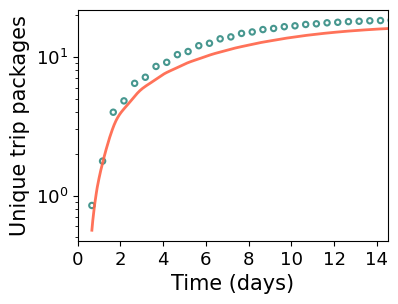

In [630]:


# plot the motifs distribution for all user days
plt.figure(figsize=(4, 3))

cutoff_min = 15
cutoff_max = 360
tgt_data = pd.DataFrame({"data": tgt_tp_time, "step": np.arange(len(tgt_tp_time))})
tgt_data = tgt_data.loc[(tgt_data["step"]>cutoff_min) & (tgt_data["step"]<cutoff_max)]



# print(tgt_data)
# tgt_plot = tgt_tp_time[cutoff_min:cutoff_max]
# pred_plot = pre_tp_time[cutoff_min:cutoff_max]
plt.scatter(tgt_data["step"].values[::12]/24, tgt_data["data"].values[::12], 
            color=sns.color_palette("crest", 20)[7], facecolors='none', 
            s=15, linewidths=1.5, label="True")

for pre_tp_time in pre_tp_time_ls:
    pred_data = pd.DataFrame({"data": pre_tp_time, "step": np.arange(len(pre_tp_time))})
    pred_data = pred_data.loc[(pred_data["step"]>cutoff_min) & (pred_data["step"]<cutoff_max)]
    # plt.plot(pred_data["step"]/24, pred_data["data"],  alpha=0.9, linewidth=2, label="True")
    plt.plot(pred_data["step"]/24, pred_data["data"],  alpha=0.9, color="tomato", linewidth=2, label="True")

# plt.plot(np.arange(len(pred_plot))+cutoff_min, pred_plot, color="tomato", linewidth=2, label=diff_file_name)

# plt.xscale("log")
plt.yscale("log")

plt.xlim([0, 14.5])
plt.xticks(np.arange(0, 16, 2))

plt.xlabel("Time (days)", fontsize=15)
plt.ylabel("Unique trip packages", fontsize=15)

plt.savefig(r'.\metrics\figures\tp_evolution.png', bbox_inches='tight', dpi=600)
plt.show()

In [625]:
# na_layer6_linear_14_200_1_200_seed102

y = np.log(tgt_data["data"])
x = np.log(tgt_data["step"]/24)
print(stats.linregress(x, y))

for pre_tp_time in pre_tp_time_ls:
    pred_data = pd.DataFrame({"data": pre_tp_time, "step": np.arange(len(pre_tp_time))})
    pred_data = pred_data.loc[(pred_data["step"]>cutoff_min) & (pred_data["step"]<cutoff_max)]
    y = np.log(pred_data["data"])
    x = np.log(pred_data["step"]/24)
    print(stats.linregress(x, y))

LinregressResult(slope=0.8454150334366967, intercept=0.8668003885892281, rvalue=0.9649705148151637, pvalue=8.166891328983278e-201, stderr=0.012429045165646033, intercept_stderr=0.024704896112291513)
LinregressResult(slope=0.8508059253462259, intercept=0.6751463434689253, rvalue=0.9714404319347534, pvalue=9.742117466292696e-216, stderr=0.011237479817080872, intercept_stderr=0.022336452056051847)


LinregressResult(slope=0.8454150334366967, intercept=0.8668003885892281, rvalue=0.9649705148151637, pvalue=8.166891328983278e-201, stderr=0.012429045165646033, intercept_stderr=0.024704896112291513)
LinregressResult(slope=0.8508059253462259, intercept=0.6751463434689253, rvalue=0.9714404319347534, pvalue=9.742117466292696e-216, stderr=0.011237479817080872, intercept_stderr=0.022336452056051847)


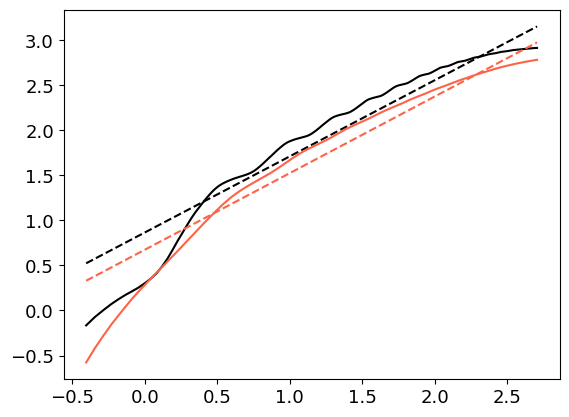

In [615]:
y = np.log(tgt_data["data"])
x = np.log(tgt_data["step"]/24)
slope, intercept, _, _, _ = stats.linregress(x, y)

plt.plot(x, y, color="k",  label="Data")
plt.plot(x, x*slope+intercept, "--", color="k")

print(stats.linregress(x, y))

y = np.log(pred_data["data"])
x = np.log(pred_data["step"]/24)

slope, intercept, _, _, _ = stats.linregress(x, y)
plt.plot(x, y, color="tomato",  label="Diffusion (Ours)")
plt.plot(x, x*slope+intercept, "--", color="tomato")

print(stats.linregress(x, y))

plt.show()

# POI - activity relation

## Read all locations

In [968]:
# initialization
config = load_config("./config/diff.yml")
config = edict(config)

In [540]:
all_locs = pd.read_csv(os.path.join("data", "s2_loc_visited_level10_14.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

In [13]:
enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
    all_locs["loc_id"].values.reshape(-1, 1)
)
all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

In [14]:
all_locs

,loc_id,level,geometry,freq,area
id,,,,,
0,1,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...
1,2,14,POINT (2822264.816 1168040.708),37,POLYGON ((10.343581795559412 46.62397697413108...
2,3,14,POINT (2822152.250 1167511.806),1,POLYGON ((10.341857399540116 46.61926019734832...
3,4,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...
4,5,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...
...,...,...,...,...,...
28736,28737,13,POINT (2767507.842 1213073.682),1,"POLYGON ((9.64763962539829 47.042237657717536,..."
28737,28738,13,POINT (2768419.907 1212986.551),1,"POLYGON ((9.65960383635977 47.04122268391671, ..."
28738,28739,13,POINT (2769332.126 1212899.406),1,"POLYGON ((9.671569607102107 47.04020629289218,..."


## Read POI

In [635]:
poi_file_path = f"data/diff/poi_level14.npy"
poi_file = np.load(poi_file_path, allow_pickle=True)
poiValues = poi_file[()]["poiValues"]

In [636]:
poiValues.shape

(28741, 32)

## Classify with kmeans

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score_ls = []
dbs_score_ls = []
for i in tqdm(range(3, 10)): 
    labels = KMeans(n_clusters=i, random_state=0, n_init=10).fit_predict(poiValues)
    sil_score_ls.append(silhouette_score(poiValues, labels))
    dbs_score_ls.append(davies_bouldin_score(poiValues, labels))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.62s/it]


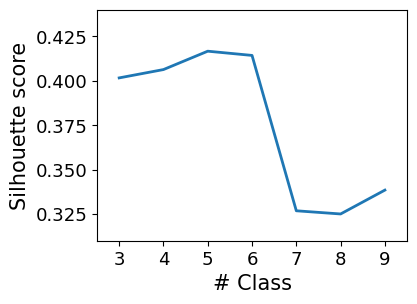

In [637]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plt.plot(np.arange(3, 10), sil_score_ls, linewidth=2, label="sil")
# plt.hlines(sil_score_ls[2], linestyle="--", xmin=0, xmax=10, color="k", linewidth=1)
# plt.plot(np.arange(3, 10), dbs_score_ls, label="dbs")

plt.ylim([0.31, 0.44])
plt.xlim([2.5, 9.5])
plt.ylabel("Silhouette score", fontsize=15)
plt.xlabel("# Class", fontsize=15)

plt.xticks(np.arange(3, 10))
# plt.legend()
# plt.savefig(r'.\metrics\figures\poi\sil_score.svg', bbox_inches='tight', dpi=600)
plt.show()

In [638]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(poiValues)

In [639]:
predict_class = kmeans.predict(poiValues)

In [640]:
loc_distance = pd.DataFrame([], columns=["loc_id", "center_dist"])
loc_distance["center_dist"] = kmeans.transform(poiValues).min(axis=1)
loc_distance["loc_id"] = np.arange(len(loc_distance))+ 1

In [641]:
# plt.hist(kmeans.transform(poiValues).min(axis=1))

loc_distance = pd.DataFrame([], columns=["loc_id", "center_dist", "class"])
loc_distance["center_dist"] = kmeans.transform(poiValues).min(axis=1)
loc_distance["other_dist"] = np.partition(kmeans.transform(poiValues), 1, axis=1)[:,1]
loc_distance["class"] = predict_class
loc_distance["loc_id"] = np.arange(len(loc_distance))+ 1

loc_distance.groupby(["class"])["center_dist"].mean(), loc_distance.groupby(["class"])["other_dist"].mean()

(class
 0    0.266308
 1    0.097331
 2    0.285007
 3    0.385016
 4    0.228973
 Name: center_dist, dtype: float64,
 class
 0    0.541261
 1    0.319136
 2    0.620561
 3    0.655899
 4    0.348162
 Name: other_dist, dtype: float64)

In [642]:
len(predict_class)

28741

In [643]:
all_locs["class"] = predict_class

### Dimension reduction for visualization

In [644]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
predict_pca = pca.fit_transform(poiValues)
print(pca.explained_variance_ratio_)

[0.6381 0.0941]


In [160]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1, random_state=42, verbose=10)
predict_tsne = tsne.fit_transform(poiValues)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28741 samples in 0.002s...
[t-SNE] Computed neighbors for 28741 samples in 0.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28741
[t-SNE] Computed conditional probabilities for sample 2000 / 28741
[t-SNE] Computed conditional probabilities for sample 3000 / 28741
[t-SNE] Computed conditional probabilities for sample 4000 / 28741
[t-SNE] Computed conditional probabilities for sample 5000 / 28741
[t-SNE] Computed conditional probabilities for sample 6000 / 28741
[t-SNE] Computed conditional probabilities for sample 7000 / 28741
[t-SNE] Computed conditional probabilities for sample 8000 / 28741
[t-SNE] Computed conditional probabilities for sample 9000 / 28741
[t-SNE] Computed conditional probabilities for sample 10000 / 28741
[t-SNE] Computed conditional probabilities for sample 11000 / 28741
[t-SNE] Computed conditional probabilities for sample 12000 / 28741
[t-SNE] Computed conditional probabilities for sam

In [162]:
predict_pca[:, 0], predict_pca[:, 1],\
predict_tsne[:,0], predict_tsne[:,1]

(array([-0.4632, -0.0311,  0.0616, ...,  0.2359,  0.1047, -0.1386]),
 array([-0.0745,  0.0785, -0.0249, ..., -0.027 , -0.0446, -0.0443]),
 array([-89.3078,  -2.2159,   3.1521, ...,  33.4705,  -7.6631, -19.1717],
       dtype=float32),
 array([-47.0584,  72.1441,  28.2775, ...,  -8.5647, -12.2321,   8.3934],
       dtype=float32))

In [645]:
all_locs["pca0"] = predict_pca[:, 0]
all_locs["pca1"] = predict_pca[:, 1]

all_locs["tsne0"] = predict_tsne[:, 0]
all_locs["tsne1"] = predict_tsne[:, 1]

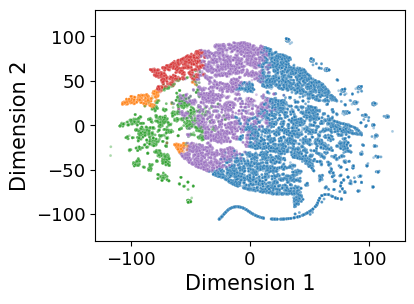

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

standard_pal = sns.color_palette(n_colors=5)
pal = sns.color_palette([standard_pal[3], standard_pal[0], standard_pal[1], standard_pal[2], standard_pal[4]])

g = sns.scatterplot(data=all_locs, x="tsne0", y="tsne1", hue="class",s=4, alpha=0.4, legend=False, 
                    palette=pal)

# g.legend_.set_title("Class")
# for lh in g.legend_.legend_handles: 
#     lh.set_alpha(1)
#     lh._sizes = [100] 

# leg = plt.legend(prop={'size': 13}, title="Class",title_fontsize=14,
#                  markerscale=2, loc='center left', bbox_to_anchor=(1, 0.5))

# for lh in leg.legendHandles: 
#     lh.set_alpha(1)

plt.ylim([-130, 130])
plt.xlim([-130, 130])

plt.ylabel("Dimension 2", fontsize=15)
plt.xlabel("Dimension 1", fontsize=15)

plt.savefig(r'.\metrics\figures\poi\tsne.svg', bbox_inches='tight', dpi=600)
plt.show()

In [166]:
pal

[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [165]:
sns.color_palette(n_colors=5)[3], sns.color_palette(n_colors=5)[0], sns.color_palette(n_colors=5)[1],\
sns.color_palette(n_colors=5)[2], sns.color_palette(n_colors=5)[4]

((0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353))

In [1338]:
print(sns.color_palette(n_colors=5).as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


### Save for visualization

In [86]:
loc_area = all_locs.drop(columns="geometry")
loc_area["area"] = loc_area["area"].apply(wkt.loads)
loc_area = gpd.GeoDataFrame(loc_area, geometry="area", crs="EPSG:4326")
loc_area.to_file(os.path.join("data", "validation","s2_loc_kmeans.shp"))

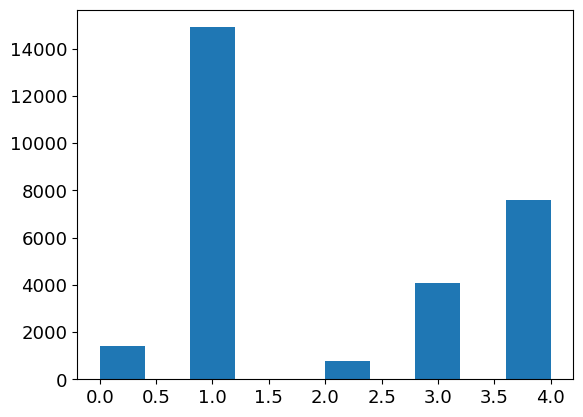

In [120]:
plt.hist(predict_class)

plt.show()

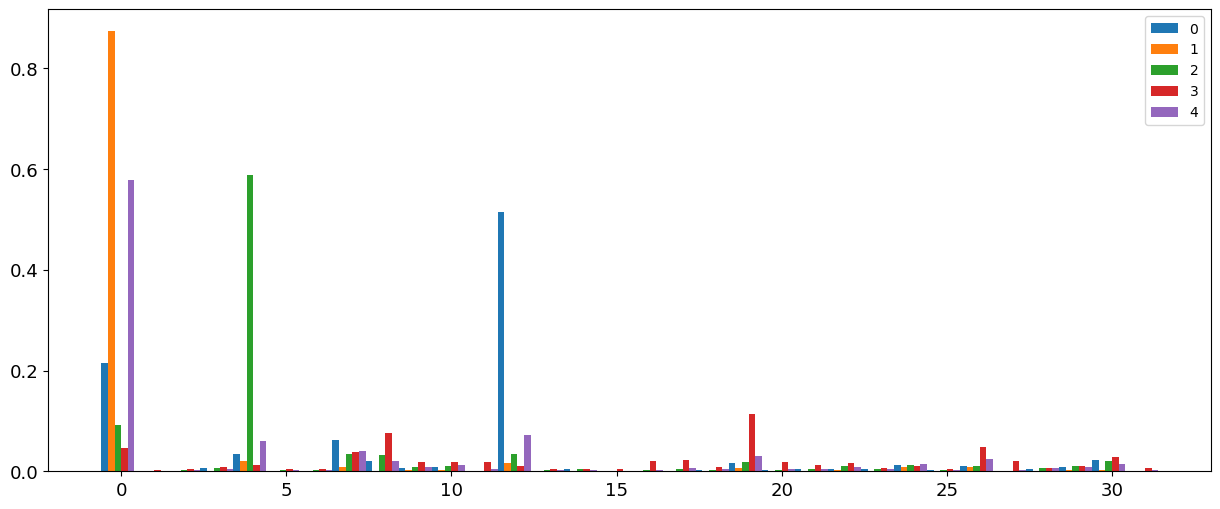

In [77]:
plt.figure(figsize=(15, 6))

x = np.arange(32)

plt.bar(x = x - 0.5, width=0.2, height = kmeans.cluster_centers_[0], label="0")
plt.bar(x = x - 0.3, width=0.2, height = kmeans.cluster_centers_[1], label="1")
plt.bar(x = x - 0.1, width=0.2, height = kmeans.cluster_centers_[2], label="2")
plt.bar(x = x + 0.1, width=0.2, height = kmeans.cluster_centers_[3], label="3")
plt.bar(x = x + 0.3, width=0.2, height = kmeans.cluster_centers_[4], label="4")

plt.legend()
plt.show()

In [76]:
np.argsort(kmeans.cluster_centers_[0])[::-1][:5],\
np.argsort(kmeans.cluster_centers_[1])[::-1][:5],\
np.argsort(kmeans.cluster_centers_[2])[::-1][:5],\
np.argsort(kmeans.cluster_centers_[3])[::-1][:5],\
np.argsort(kmeans.cluster_centers_[4])[::-1][:5]

(array([12,  0,  7,  4, 30], dtype=int64),
 array([ 0,  4, 12,  7, 26], dtype=int64),
 array([ 4,  0, 12,  7,  8], dtype=int64),
 array([19,  8, 26,  0,  7], dtype=int64),
 array([ 0, 12,  4,  7, 19], dtype=int64))

In [73]:
kmeans.cluster_centers_[0]

array([0.2155, 0.0001, 0.0015, 0.0059, 0.0344, 0.0008, 0.0003, 0.0624,
       0.0212, 0.0063, 0.0095, 0.0005, 0.5141, 0.0005, 0.004 , 0.0001,
       0.0005, 0.0014, 0.0018, 0.0161, 0.0016, 0.0037, 0.0054, 0.0037,
       0.0123, 0.0021, 0.0105, 0.0006, 0.005 , 0.008 , 0.0226, 0.0002])

In [72]:
kmeans.cluster_centers_[0][np.argsort(kmeans.cluster_centers_[0])]

array([0.0001, 0.0001, 0.0002, 0.0003, 0.0005, 0.0005, 0.0005, 0.0006,
       0.0008, 0.0014, 0.0015, 0.0016, 0.0018, 0.0021, 0.0037, 0.0037,
       0.004 , 0.005 , 0.0054, 0.0059, 0.0063, 0.008 , 0.0095, 0.0105,
       0.0123, 0.0161, 0.0212, 0.0226, 0.0344, 0.0624, 0.2155, 0.5141])

## Interprete classes

In [121]:
# read poi file
poi = gpd.read_file(os.path.join("data", "poi", "final_pois.shp"))
spatial_index = poi.sindex

In [122]:
len(poi), poi["code"].value_counts().sum()

(3104590, 3104590)

In [123]:
loc_area = all_locs.drop(columns="geometry")
loc_area["area"] = loc_area["area"].apply(wkt.loads)
loc_area = gpd.GeoDataFrame(loc_area, geometry="area", crs="EPSG:4326")
loc_area = loc_area.to_crs("EPSG:2056")

In [1353]:
def _get_inside_pois(df, poi, spatial_index):
    """
    Given one extent (df), return the poi within this extent.
    spatial_index is obtained from poi.sindex to speed up the process.
    """
    possible_matches_index = list(spatial_index.intersection(df.bounds))
    possible_matches = poi.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.within(df)]["id"].values

    return precise_matches

# get the inside poi within each location
tqdm.pandas(desc="Generating poi within")
loc_area["poi_within"] = loc_area["area"].progress_apply(
    _get_inside_pois, poi=poi, spatial_index=spatial_index
)

Generating poi within: 100%|████████████████████████████████████████████████████| 28741/28741 [00:42<00:00, 683.75it/s]


In [1390]:
loc_poi_pair = (loc_area[["loc_id", "class", "poi_within"]]
                .explode("poi_within").dropna(subset="poi_within"))
loc_poi_pair = loc_poi_pair.merge(poi[["id", "code", "category"]], 
                   left_on="poi_within", right_on="id")

In [1392]:
loc_poi_pair["category"].value_counts()

category
Others            2008666
Transportation     112958
Entertainment      108105
Residential         45186
Shopping            44396
Services             9188
Schools              8402
Civic                5015
Name: count, dtype: int64

In [1378]:
class_p = (loc_poi_pair
           .groupby(["class"],as_index=False)["category"]
           .value_counts(normalize=True, sort=False))
all_p = (loc_poi_pair["category"]
         .value_counts(normalize=True, sort=False)
         .to_frame().reset_index())
cate_p = class_p.merge(all_p, on="category")
cate_p["ei"] = cate_p["proportion_x"]/cate_p["proportion_y"]
cate_p.set_index("category").stack()

In [1389]:
cate_p.pivot(index='category', columns='class', values='ei')

class,0,1,2,3,4
category,,,,,
Civic,1.432525,0.840965,0.495969,1.118484,1.232052
Entertainment,1.260970,0.577435,5.090741,6.394670,1.484650
Others,0.762860,1.079273,0.718797,0.638501,0.932819
Residential,3.356920,0.485257,1.137606,1.248068,1.276063
Schools,2.063909,0.583164,2.883598,0.414996,1.545133
Services,4.836591,0.289004,0.270710,0.272246,1.232660
Shopping,4.545309,0.339158,0.751149,0.886120,1.176301
Transportation,2.220512,0.556279,2.069837,2.308397,1.481310


In [1427]:
class_p = (loc_poi_pair
           .groupby(["class"],as_index=False)["code"]
           .value_counts(normalize=True, sort=False))
all_p = (loc_poi_pair["code"]
         .value_counts(normalize=True, sort=False)
         .to_frame().reset_index())
cate_p = class_p.merge(all_p, on="code")
cate_p["ei"] = cate_p["proportion_x"]/cate_p["proportion_y"]
cate_p = cate_p.pivot(index='code', columns='class', values='ei').dropna()

In [1429]:
valid_idx = loc_poi_pair["code"].value_counts()[loc_poi_pair["code"].value_counts()>1000].index
cate_p[cate_p.index.isin(valid_idx)].iloc[1:].index

Index([2002, 2004, 2005, 2007, 2008, 2015, 2030, 2031, 2082, 2083, 2101, 2120,
       2204, 2205, 2251, 2252, 2253, 2301, 2302, 2303, 2305, 2401, 2421, 2501,
       2502, 2503, 2511, 2541, 2542, 2561, 2565, 2592, 2593, 2601, 2602, 2701,
       2722, 2725, 2741, 2742, 2901, 2902, 2903, 2904, 2906, 2907, 3100, 3102,
       4111, 5201, 5203, 5250, 5260, 5263, 5270, 5601, 5603, 5621],
      dtype='int64', name='code')

In [1469]:
pd.options.display.float_format = '{:,.2f}'.format

code_map = {2002: "public", 2004: "public", 2005: "public", 2007:"public", 2008:"public", 
            2015: "public", 
            2030: "public", 2031: "public", 2082: "public", 2083: "public", 
            2101: "health", 2120: "health", 
            2204: "leisure", 2205: "leisure", 2251: "leisure", 2252: "leisure", 2253: "leisure", 
            2301: "catering", 2302: "catering", 2303: "catering", 2305: "catering", 
            2401: "accommodation", 2421: "accommodation", 
            2501: "shopping", 2502: "shopping",2503: "shopping", 
            2511: "shopping", 2541: "shopping", 2542: "shopping", 2561: "shopping", 2565: "shopping", 
            2592: "shopping", 2593: "shopping", 2601: "money", 2602: "money", 
            2701: "tourism", 2722: "tourism", 2725: "tourism", 2741: "tourism", 2742: "tourism", 
            2901: "others", 2902: "others", 2903: "others", 2904: "others", 2906: "others", 2907: "others", 
            3100: "pofw", 3102: "pofw", 4111: "natural", 5201: "traffic", 5203: "traffic", 5250: "traffic",
            5260: "traffic", 5263: "traffic", 5270: "traffic", 5601: "traffic", 5603: "traffic", 5621: "traffic"}
loc_poi_pair["code_class"] = loc_poi_pair["code"].map(code_map)

class_p = (loc_poi_pair
           .groupby(["class"],as_index=False)["code_class"]
           .value_counts(normalize=True, sort=False))
all_p = (loc_poi_pair["code_class"]
         .value_counts(normalize=True, sort=False)
         .to_frame().reset_index())
cate_p = class_p.merge(all_p, on="code_class")
cate_p["ei"] = cate_p["proportion_x"]/cate_p["proportion_y"]
cate_p = cate_p.pivot(index='code_class', columns='class', values='ei').dropna()
cate_p

class,0,1,2,3,4
code_class,,,,,
accommodation,1.28,0.90,0.41,0.92,0.97
catering,1.88,0.71,0.44,0.43,0.82
health,2.31,0.46,0.12,0.04,0.85
leisure,0.48,1.22,3.26,0.28,1.08
money,2.21,0.56,0.04,0.06,0.82
natural,0.04,0.86,0.14,7.15,0.87
others,1.01,0.83,0.87,1.81,1.03
pofw,0.56,1.68,0.22,0.32,0.85
public,0.90,1.26,0.66,0.13,0.99


## Read visits 

In [631]:
file_dir = [    
    ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed102.json", 
]

LENGTH = 50
MIN_PER_DAY = 60*24

pred_df_all = []
tgt_df = pd.DataFrame()

tgt = {
    "loc": [],
    "dur": [],
    "mode":[],
    "idx": [],
    "day": [],
    "day_min":[],
    "time":[],
}
src = {
    "loc":[],
    "dur":[],
    "mode":[],
    "idx":[],
}

def get_unpadded_sequence(content, dataset="target"):
    locations = np.array(content[dataset])
    if dataset=="target":
        dur_seq = "tgt_dur"
        mode_seq = "tgt_mode"
        times = np.array(content["tgt_time"])
    else:
        dur_seq = "src_dur"
        mode_seq = "src_mode"
    # durations = (np.array(content[dur_seq]) + 1) / 2 * (MIN_PER_DAY * 2)
    durations = np.array(content[dur_seq])
    modes = np.array(content[mode_seq])

    if dataset=="target":
        try:
            length = np.where(locations == 0)[0][0]
        except IndexError:
            length = len(locations)
        
        locations = locations[:length]
        durations = durations[:length]
        modes = modes[:length]
        times = times[:length]
        
        return locations, durations, modes, times
        # return locations, durations, modes
    else:
        try:
            length = np.where(locations == 0)[0][0]
            
            locations = locations[:length]
            durations = durations[:length]
            modes = modes[:length]
        except IndexError:
            pass
        return locations, durations, modes
    
for i, file in enumerate(file_dir):
    predict = {
        "loc": [],
        "dur": [],
        "mode":[],
        "idx": [],
        "day": [],
        "day_min":[],
        "time":[],
    }
    with open(file, "r") as f_reader:
        for record_idx, row in enumerate(f_reader):
            content = json.loads(row)
            src_locs, src_dur, src_mode = get_unpadded_sequence(content, dataset="source")
            
            start_time = np.array(content["seq_time"])[len(src_locs) - 1]

            if i == 0:
                src["idx"].extend(np.repeat(record_idx,len(src_locs)))
                src["loc"].extend(src_locs)
                src["dur"].extend(src_dur)
                src["mode"].extend(src_mode)
                
                tgt_locs, tgt_dur, tgt_mode, tgt_time = get_unpadded_sequence(content, dataset="target")
                # tgt_locs, tgt_dur, tgt_mode = get_unpadded_sequence(content, dataset="target")

                tgt["idx"].extend(np.repeat(record_idx,len(tgt_locs)))
                tgt["loc"].extend(tgt_locs)
                tgt["dur"].extend(tgt_dur)
                tgt["mode"].extend(tgt_mode)
                tgt["time"].extend(tgt_time)

                abs_time = start_time + np.cumsum(tgt_dur)
                tgt["day"].extend((abs_time // MIN_PER_DAY).astype(int))
                tgt["day_min"].extend(abs_time % MIN_PER_DAY)


            predict["idx"].extend(np.repeat(record_idx,LENGTH))
            predict["loc"].extend(np.array(content["recover"][:LENGTH]).squeeze())
            predict["mode"].extend(np.array(content["mode"][:LENGTH]).squeeze())
            predict["time"].extend(np.array(content["time"][:LENGTH]).squeeze())
            
            duration = np.array(content["duration"][:LENGTH]).squeeze()
            predict["dur"].extend(duration)
            
            abs_time = start_time + np.cumsum(duration)
            predict["day"].extend((abs_time // MIN_PER_DAY).astype(int))
            predict["day_min"].extend(abs_time % MIN_PER_DAY)

    if  i == 0:
        src_df = pd.DataFrame(src)
        tgt_df = pd.DataFrame(tgt)
    pred_df_all.append(pd.DataFrame(predict))

In [632]:
print(tgt_df["loc"].max(), src_df["loc"].max())
print([df["loc"].max() for df in pred_df_all])

28741 28741
[28738]


In [633]:
for df in pred_df_all:
    df.loc[df["loc"]>28741, "loc"] = 28741

In [646]:
def get_previous_jump_length(df):
    df["jump"] = df["geometry"].distance(df["geometry"].shift(1))
    return df

def construct_df(df, all_locs, loc_distance):
    info_df = df.merge(all_locs[["loc_id", "class", "pca0", "pca1", "geometry"]], left_on="loc", right_on="loc_id", how="left")
    
    info_df = gpd.GeoDataFrame(info_df, geometry="geometry", crs="EPSG:2056")
    info_df = info_df.groupby("idx", as_index=False).apply(get_previous_jump_length)
    info_df = info_df.reset_index(drop=True).drop(columns="geometry").fillna(0)
    
    info_df = info_df.merge(loc_distance.drop(columns="class"), on="loc_id", how="left")

    return info_df

pred_info_df = construct_df(pred_df_all[0], all_locs, loc_distance)
tgt_info_df = construct_df(tgt_df, all_locs, loc_distance)

C:\Users\hong\AppData\Local\Temp\ipykernel_37476\2438173961.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  info_df = info_df.groupby("idx", as_index=False).apply(get_previous_jump_length)
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\2438173961.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  info_df = info_df.groupby("idx", as_index=False).apply(get_previous_jump_length)


In [647]:
def get_HHI(df):
    mode_freq = df["mode"].value_counts()
    mode_freq = mode_freq/mode_freq.sum()
    return np.power(mode_freq, 2).sum()
    

pred_final_df = pred_info_df.groupby("loc")[["class", "center_dist", "dur", "jump"]].mean()
# pred_final_df = pred_info_df.groupby("loc")[["jump", "class", "center_dist"]].mean()
pred_final_df["freq"] = pred_info_df.groupby("loc").size()
pred_final_df["jump_median"] = pred_info_df.groupby("loc")["jump"].median()
pred_final_df["mode_hhi"] = pred_info_df.groupby("loc").apply(get_HHI)
# pred_final_df = pred_final_df.loc[pred_final_df.freq > 100]

tgt_final_df = tgt_info_df.groupby("loc")[["class", "other_dist", "center_dist", "dur", "jump"]].mean()
# tgt_final_df = tgt_info_df.loc[tgt_info_df["jump"]!=0].groupby("loc")[["class", "other_dist", "center_dist", "dur"]].mean()
tgt_final_df["freq"] = tgt_info_df.groupby("loc").size()
tgt_final_df["jump_median"] = tgt_info_df.groupby("loc")["jump"].median()
tgt_final_df["mode_hhi"] = tgt_info_df.groupby("loc").apply(get_HHI)

# tgt_final_df = tgt_final_df.sort_values(by="freq",ascending=False).groupby("class").head(50)
# tgt_final_df = tgt_final_df.loc[tgt_final_df.freq > 10]
# tgt_final_df = tgt_final_df.loc[tgt_final_df.dur > 1000]

C:\Users\hong\AppData\Local\Temp\ipykernel_37476\3352722880.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_final_df["mode_hhi"] = pred_info_df.groupby("loc").apply(get_HHI)
C:\Users\hong\AppData\Local\Temp\ipykernel_37476\3352722880.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tgt_final_df["mode_hhi"] = tgt_info_df.groupby("loc").apply(get_HHI)


In [648]:
pred_final_df.corr()

,class,center_dist,dur,jump,freq,jump_median,mode_hhi
class,1.000000,0.365547,-0.026014,0.071520,-0.076635,0.070832,0.027100
center_dist,0.365547,1.000000,-0.070504,0.081105,0.001814,0.076401,-0.047935
dur,-0.026014,-0.070504,1.000000,0.032297,0.122580,0.037272,-0.023711
jump,0.071520,0.081105,0.032297,1.000000,-0.146443,0.970757,0.147613
freq,-0.076635,0.001814,0.122580,-0.146443,1.000000,-0.140316,-0.155194
jump_median,0.070832,0.076401,0.037272,0.970757,-0.140316,1.000000,0.180664
mode_hhi,0.027100,-0.047935,-0.023711,0.147613,-0.155194,0.180664,1.000000


In [649]:
tgt_final_df.corr()

,class,other_dist,center_dist,dur,jump,freq,jump_median,mode_hhi
class,1.000000,-0.179832,0.252839,-0.004872,-0.001695,-0.095361,0.013361,0.093347
other_dist,-0.179832,1.000000,0.573266,-0.033271,0.012189,0.070048,-0.006571,-0.107035
center_dist,0.252839,0.573266,1.000000,-0.066809,0.005211,0.007621,0.002570,-0.062079
dur,-0.004872,-0.033271,-0.066809,1.000000,0.182249,0.139967,0.142524,-0.090849
jump,-0.001695,0.012189,0.005211,0.182249,1.000000,-0.061614,0.923022,0.089841
freq,-0.095361,0.070048,0.007621,0.139967,-0.061614,1.000000,-0.092993,-0.349725
jump_median,0.013361,-0.006571,0.002570,0.142524,0.923022,-0.092993,1.000000,0.193167
mode_hhi,0.093347,-0.107035,-0.062079,-0.090849,0.089841,-0.349725,0.193167,1.000000


In [650]:
pred_final_df.groupby(["class"])["center_dist"].mean(), pred_final_df.groupby(["class"])["freq"].mean()

(class
 0.0    0.261387
 1.0    0.099992
 2.0    0.286210
 3.0    0.397145
 4.0    0.223444
 Name: center_dist, dtype: float64,
 class
 0.0    485.638370
 1.0    144.410575
 2.0     55.483766
 3.0     22.263209
 4.0    134.311020
 Name: freq, dtype: float64)

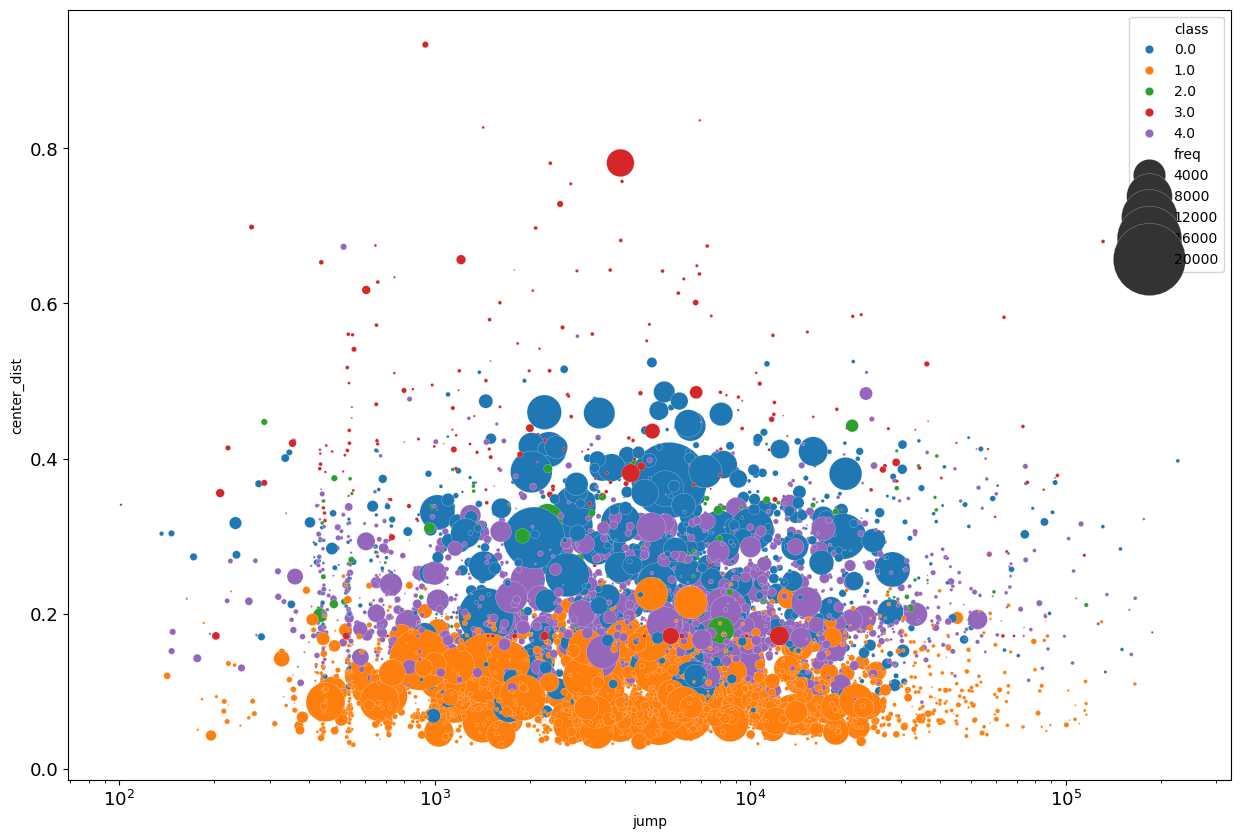

In [651]:
plt.figure(figsize=(15, 10))

minsize = min(tgt_final_df['freq'])
maxsize = max(tgt_final_df['freq'])**0.8

pal = sns.color_palette(n_colors=5)

sns.scatterplot(data=tgt_final_df, x="jump", y="center_dist", hue="class", size="freq", sizes=(minsize, maxsize), palette=pal)
# sns.scatterplot(data=pred_final_df, x="freq", y="center_dist", hue="class", palette=pal)
# sns.kdeplot(data=tgt_final_df, x="freq", hue="class", palette=pal)

plt.xscale("log")
# plt.yscale("log")

plt.show()

In [652]:
tgt_final_df["in_pred"] = tgt_final_df.reset_index()["loc"].apply(lambda x: x in pred_final_df.reset_index()["loc"].values).values
pred_final_df["in_tgt"] = pred_final_df.reset_index()["loc"].apply(lambda x: x in tgt_final_df.reset_index()["loc"].values).values

In [653]:
tgt_final_df["in_pred"].value_counts(), pred_final_df["in_tgt"].value_counts(),\
tgt_final_df["in_pred"].value_counts()/len(tgt_final_df), pred_final_df["in_tgt"].value_counts()/len(pred_final_df)

(in_pred
 True     3886
 False    1007
 Name: count, dtype: int64,
 in_tgt
 False    7187
 True     3886
 Name: count, dtype: int64,
 in_pred
 True     0.794196
 False    0.205804
 Name: count, dtype: float64,
 in_tgt
 False    0.649056
 True     0.350944
 Name: count, dtype: float64)

In [654]:
exist_loc = pred_final_df.loc[pred_final_df["in_tgt"]]
explore_loc = pred_final_df.loc[~pred_final_df["in_tgt"]]

exist_loc_tgt = tgt_final_df.loc[tgt_final_df["in_pred"]]
explore_loc_tgt = tgt_final_df.loc[~tgt_final_df["in_pred"]]

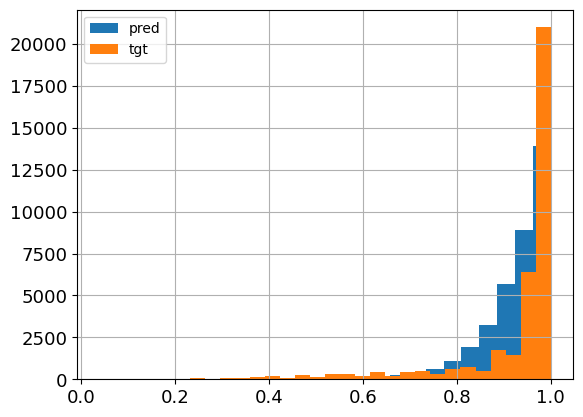

In [655]:
fig, ax = plt.subplots()

# 
pred_freq = (pred_info_df.merge(pred_final_df.reset_index()[["loc", "in_tgt"]], on="loc")
             .groupby("idx", as_index=False)["in_tgt"].value_counts())
pred_freq["count"] = pred_freq["count"] / 50
pred_freq.loc[pred_freq["in_tgt"]]["count"].hist(ax=ax, bins=20, label="pred")

# 
tgt_freq = (tgt_info_df.merge(tgt_final_df.reset_index()[["loc", "in_pred"]], on="loc")
             .groupby("idx", as_index=False)["in_pred"].value_counts())
tgt_freq["count"] = tgt_freq["count"] / 50
tgt_freq.loc[tgt_freq["in_pred"]]["count"].hist(ax=ax, bins=30, label="tgt")

plt.legend()
plt.show()

In [656]:
tgt_final_df["in_pred"].value_counts()/len(tgt_final_df), pred_final_df["in_tgt"].value_counts()/len(pred_final_df)

(in_pred
 True     0.794196
 False    0.205804
 Name: count, dtype: float64,
 in_tgt
 False    0.649056
 True     0.350944
 Name: count, dtype: float64)

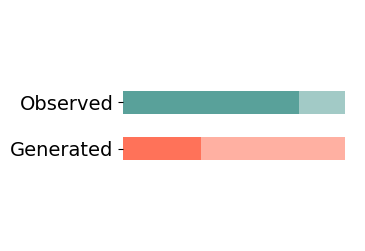

In [657]:
pred_sum = len(exist_loc) + len(explore_loc)
tgt_sum = len(exist_loc_tgt) + len(explore_loc_tgt)

weight_counts = {
    "Below": np.array([len(exist_loc)/pred_sum, len(exist_loc_tgt)/tgt_sum]),
    "Above": np.array([len(explore_loc)/pred_sum, len(explore_loc_tgt)/tgt_sum]),
}
width = 0.2

fig, ax = plt.subplots(figsize=(3,3))

label=["Generated", "Observed"]
color = ["tomato", sns.color_palette("crest", 20)[7]]

bottom = np.zeros(2)
ax.barh(y=label, width=weight_counts["Below"], color=color, height=0.5,  alpha=0.9, left=bottom)
bottom += weight_counts["Below"]
ax.barh(y=label, width=weight_counts["Above"], color=color, height=0.5, alpha=0.5, left=bottom)

plt.ylim([-2, 3])
plt.xticks([])

# ax.set_title("Proportion of observed locations", fontsize=15, y=1, pad=-30)
plt.yticks(fontsize=14)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.savefig(r'.\metrics\figures\poi\loc_unique.svg', bbox_inches='tight', dpi=600)

plt.show()

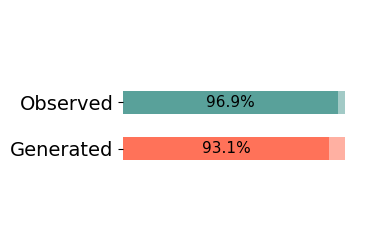

In [659]:
pred_sum = exist_loc["freq"].sum() + explore_loc["freq"].sum()
tgt_sum = exist_loc_tgt["freq"].sum() + explore_loc_tgt["freq"].sum()

weight_counts = {
    "Below": np.array([exist_loc["freq"].sum()/pred_sum * 100, exist_loc_tgt["freq"].sum()/tgt_sum * 100]),
    "Above": np.array([explore_loc["freq"].sum()/pred_sum * 100, explore_loc_tgt["freq"].sum()/tgt_sum * 100]),
}


fig, ax = plt.subplots(figsize=(3,3))

label=["Generated", "Observed"]
color = ["tomato", sns.color_palette("crest", 20)[7]]

bottom = np.zeros(2)
bars = ax.barh(y=label, width=weight_counts["Below"], color=color, height=0.5, alpha=0.9, left=bottom)
ax.bar_label(bars, fmt='%.1f%%', label_type='center', fontsize=11)
bottom += weight_counts["Below"]
ax.barh(y=label, width=weight_counts["Above"], color=color, height=0.5, alpha=0.5, left=bottom)

plt.ylim([-2, 3])
plt.xticks([])

# ax.set_title("Proportion of visits", fontsize=15, y=1, pad=-40)
plt.yticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.savefig(r'.\metrics\figures\poi\loc_visits.svg', bbox_inches='tight', dpi=600)
plt.show()

427.11380690345175 12.996466000487448 422.09479739869937 50.6


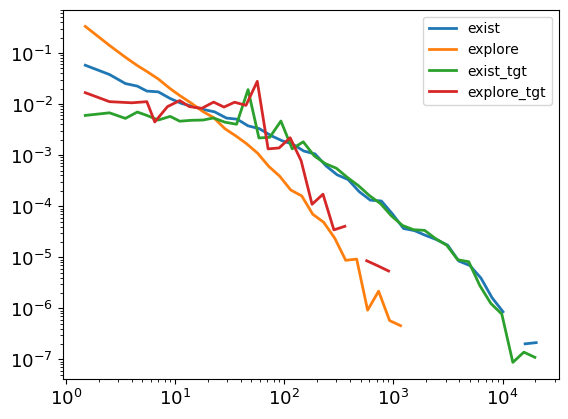

In [365]:
powerlaw.plot_pdf(exist_loc["freq"], label=f"exist", linewidth=2)
powerlaw.plot_pdf(explore_loc["freq"], label=f"explore", linewidth=2)

powerlaw.plot_pdf(exist_loc_tgt["freq"], label=f"exist_tgt", linewidth=2)
powerlaw.plot_pdf(explore_loc_tgt["freq"], label=f"explore_tgt", linewidth=2)

plt.legend()

print(exist_loc["freq"].mean(), explore_loc["freq"].mean(), exist_loc_tgt["freq"].mean(), explore_loc_tgt["freq"].mean())

plt.show()

22229.339981172936 63038.4443687696 7777.104325715742 11298.636511753179


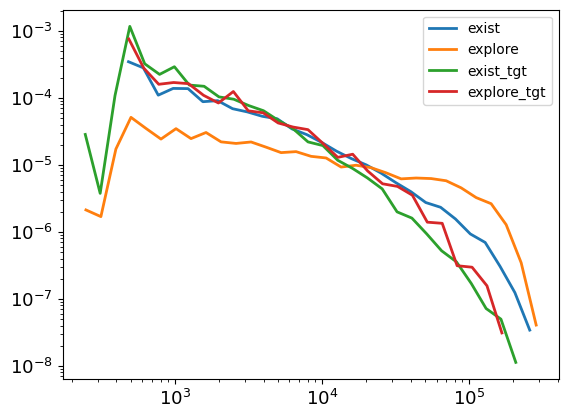

In [366]:
powerlaw.plot_pdf(exist_loc.loc[exist_loc["jump_median"]>0, "jump_median"], label=f"exist", linewidth=2)
powerlaw.plot_pdf(explore_loc.loc[explore_loc["jump_median"]>0, "jump_median"], label=f"explore", linewidth=2)

powerlaw.plot_pdf(exist_loc_tgt.loc[exist_loc_tgt["jump_median"]>0, "jump_median"], label=f"exist_tgt", linewidth=2)
powerlaw.plot_pdf(explore_loc_tgt.loc[explore_loc_tgt["jump_median"]>0, "jump_median"], label=f"explore_tgt", linewidth=2)

# exist_loc
plt.legend()

print(exist_loc["jump_median"].mean(), explore_loc["jump_median"].mean(), exist_loc_tgt["jump_median"].mean(), explore_loc_tgt["jump_median"].mean())

plt.show()

<Figure size 1500x1000 with 0 Axes>

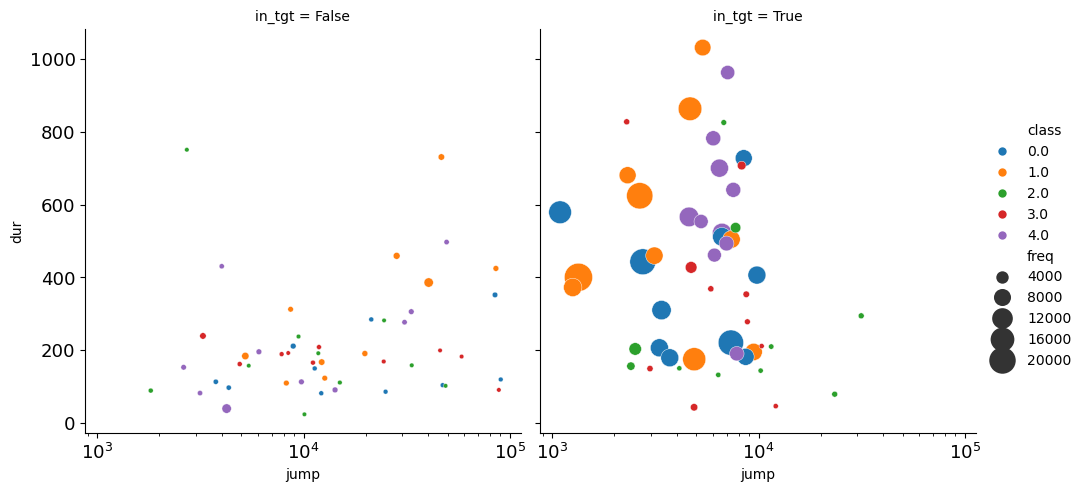

In [385]:
plt.figure(figsize=(15, 10))



pal = sns.color_palette(n_colors=5)
temp_pred = pred_final_df.sort_values(by="freq",ascending=False).groupby(["class", "in_tgt"]).head(10)

minsize = 10
maxsize = max(temp_pred['freq'])**0.6

sns.relplot(
    data=temp_pred, x="jump", y="dur",
    col="in_tgt", hue="class", size="freq", sizes=(minsize, maxsize), palette=pal,
    kind="scatter"
)

# sns.scatterplot(data=pred_final_df, x="jump", y="in_tgt", hue="class", size="freq", sizes=(minsize, maxsize), palette=pal)

plt.xscale("log")
# plt.yscale("log")

plt.show()

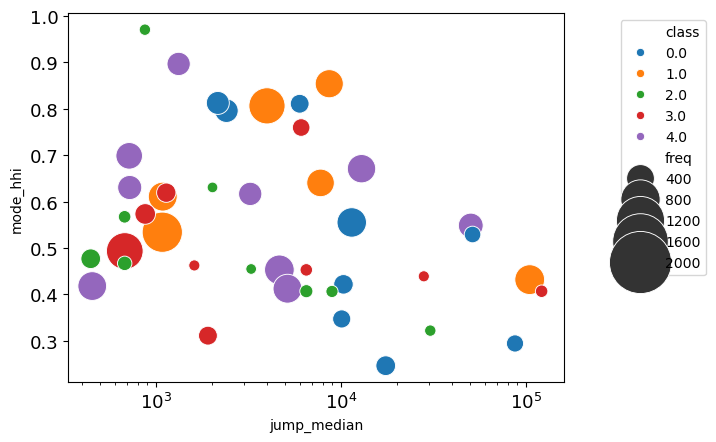

In [718]:
temp_pred = pred_final_df.sort_values(by="freq",ascending=False).groupby(["class", "in_tgt"]).head(10)
temp_pred = temp_pred[temp_pred["in_tgt"]==False]

minsize = min(temp_pred['freq'])
maxsize = max(temp_pred['freq'])**1

sns.scatterplot(data=temp_pred, x="jump_median", 
                y="mode_hhi", hue="class", size="freq", 
                sizes=(minsize, maxsize), palette=pal)

plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
# plt.legend(loc=9)
# plt.yscale("log")
plt.xscale("log")

In [714]:
explore_loc.groupby("class").mean()

,center_dist,dur,jump,freq,jump_median,mode_hhi,in_tgt
class,,,,,,,
0.0,0.274944,219.675942,65554.646436,23.165775,61241.823632,0.650288,0.0
1.0,0.097771,263.714173,62228.385565,13.402557,59019.237017,0.768209,0.0
2.0,0.292598,265.479617,67866.603468,10.109023,63731.618551,0.717590,0.0
3.0,0.395481,207.937267,77728.496823,6.736842,76259.436500,0.796554,0.0
4.0,0.227115,244.140503,67801.542531,13.550548,64996.962943,0.721899,0.0


In [716]:
explore_loc.corr()

,class,center_dist,dur,jump,freq,jump_median,mode_hhi,in_tgt
class,1.000000,0.470509,-0.025900,0.060586,-0.022878,0.063027,-0.030602,NaN
center_dist,0.470509,1.000000,-0.049487,0.084375,-0.020313,0.084996,-0.004007,NaN
dur,-0.025900,-0.049487,1.000000,0.085029,-0.021845,0.087466,0.021546,NaN
jump,0.060586,0.084375,0.085029,1.000000,-0.135698,0.974124,0.095035,NaN
freq,-0.022878,-0.020313,-0.021845,-0.135698,1.000000,-0.147577,-0.172765,NaN
jump_median,0.063027,0.084996,0.087466,0.974124,-0.147577,1.000000,0.114600,NaN
mode_hhi,-0.030602,-0.004007,0.021546,0.095035,-0.172765,0.114600,1.000000,NaN
in_tgt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## POI-location visit relation

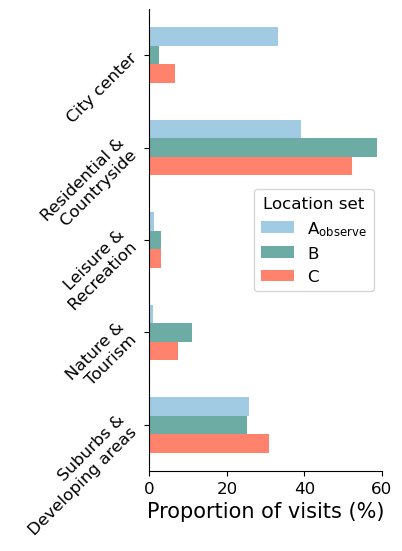

In [661]:
plt.figure(figsize=(3, 6))

tgt_exist = (exist_loc_tgt.groupby("class")["freq"].sum()/exist_loc_tgt["freq"].sum()).to_frame().reset_index()
tgt_explore = (explore_loc_tgt.groupby("class")["freq"].sum()/explore_loc_tgt["freq"].sum()).to_frame().reset_index()

pred_exist = (exist_loc.groupby("class")["freq"].sum()/exist_loc["freq"].sum()).to_frame().reset_index()
pred_explore = (explore_loc.groupby("class")["freq"].sum()/explore_loc["freq"].sum()).to_frame().reset_index()

tgt_exist["freq"] = tgt_exist["freq"]*100
tgt_explore["freq"] = tgt_explore["freq"]*100
pred_explore["freq"] = pred_explore["freq"]*100

tgt_exist["Location set"] = "A"
# pred_exist["Location set"] = "A_"
tgt_explore["Location set"] = "B"
pred_explore["Location set"] = "C"

pal = sns.color_palette([sns.color_palette(palette='Blues')[2],  sns.color_palette("crest", 20)[7], "tomato"])

vis_df = pd.concat([tgt_exist, tgt_explore, pred_explore])
vis_df["class"] = vis_df["class"].map({0: "City center", 1: "Residential &\n Countryside", 
            2: "Leisure &\n Recreation", 3: "Nature &\n Tourism", 4:"Suburbs &\n Developing areas"})

g = sns.barplot(vis_df, width=0.6, y="class", x="freq", 
            hue="Location set", saturation=1, alpha=0.8, palette=pal, orient = 'h')

legend_handles, _ = g.get_legend_handles_labels()
g.legend(legend_handles, ['$\mathregular{A_{observe}}$','B','C'], prop={"size": 12}, title_fontsize=12,
         frameon=True, title="Location set", loc="center right")

# plt.legend()
plt.ylabel("")
plt.xlabel("Proportion of visits (%)", fontsize=15)

plt.yticks(rotation=45, ha='right', fontsize=12)
plt.xticks(np.arange(0, 65, 20), fontsize=12)
plt.xlim(0, 60)


sns.despine(bottom = False, left = False)

plt.savefig(r'.\metrics\figures\poi\loc_visits_class.svg', bbox_inches='tight', dpi=600)
plt.show()

In [662]:
wasserstein_distance(np.arange(len(tgt_exist)), np.arange(len(tgt_exist)), tgt_exist["freq"], tgt_explore["freq"]),\
wasserstein_distance(np.arange(len(tgt_exist)), np.arange(len(tgt_exist)), tgt_exist["freq"], pred_explore["freq"]),\
wasserstein_distance(np.arange(len(tgt_exist)), np.arange(len(tgt_exist)), tgt_explore["freq"], pred_explore["freq"])

(0.517339162883897, 0.5679630202727279, 0.14631031852964987)

In [663]:
data_ls = [tgt_exist, tgt_explore, pred_exist, pred_explore]

distance_matrix = np.zeros((4, 4))
for i, data_i in enumerate(data_ls):
    for j, data_j in enumerate(data_ls):
        distance_matrix[i, j] = wasserstein_distance(np.arange(len(data_i)), np.arange(len(data_j)), data_i["freq"], data_j["freq"])


condition = np.tril(np.ones((distance_matrix.shape)), k = -1).astype(bool)
triangle = np.where(condition, distance_matrix, np.nan)
triangle

array([[   nan,    nan,    nan,    nan],
       [0.5173,    nan,    nan,    nan],
       [0.0312, 0.5376,    nan,    nan],
       [0.568 , 0.1463, 0.5991,    nan]])

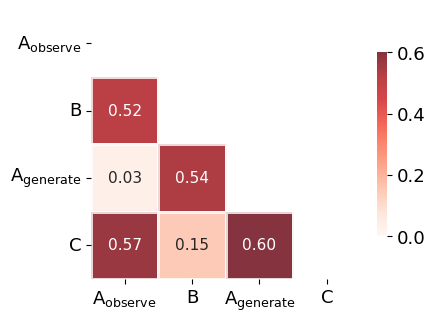

In [665]:
FEATURES_SIMBOL = ['$\mathregular{A_{observe}}$','B','$\mathregular{A_{generate}}$', 'C']


fig = plt.figure(figsize=(4, 4))
# ax = fig.add_subplot(111, axes_class=axisartist.Axes)
ax = fig.add_subplot(111)

img = sns.heatmap(triangle, annot=True, square=True, fmt='.2f', vmin=0, vmax=0.6, 
                  linewidths=1, alpha=0.8, cmap="Reds", annot_kws={"size": 11}, cbar_kws={"shrink":0.5},
                  xticklabels=FEATURES_SIMBOL, yticklabels=FEATURES_SIMBOL) 
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.tight_layout()

plt.yticks(rotation=0) 
# plt.savefig(os.path.join("fig", "correlation.png"), bbox_inches='tight', dpi=600)
plt.savefig(r'.\metrics\figures\poi\distance.svg', bbox_inches='tight', dpi=600)

plt.show()

In [720]:
pred_mode_df = pred_info_df.groupby(["loc", "mode"])[["class", "center_dist", "dur", "jump"]].mean()
# pred_final_df = pred_info_df.groupby("loc")[["jump", "class", "center_dist"]].mean()
pred_mode_df["freq"] = pred_info_df.groupby(["loc",  "mode"]).size()
pred_mode_df["jump_median"] = pred_info_df.groupby(["loc",  "mode"])["jump"].median()
pred_mode_df = pred_mode_df.reset_index()

pred_mode_df = pred_mode_df.merge(pred_final_df.reset_index()[["loc", "in_tgt"]], on="loc")

In [721]:
pred_mode_df

,loc,mode,class,center_dist,dur,jump,freq,jump_median,in_tgt
0,2,1,4.0,0.170671,2139.601990,167117.027972,2,167117.027972,True
1,2,3,4.0,0.170671,1736.978027,144996.391282,3,125060.872049,True
2,2,5,4.0,0.170671,1600.278503,210406.620035,2,210406.620035,True
3,2,7,4.0,0.170671,1028.158484,84282.935857,6,99521.681763,True
4,4,2,3.0,0.171170,132.248993,196005.228965,1,196005.228965,False
...,...,...,...,...,...,...,...,...,...
30707,28723,3,1.0,0.081100,74.402000,25798.928781,1,25798.928781,False
30708,28724,3,1.0,0.101951,55.010501,99485.226281,2,99485.226281,False
30709,28726,3,1.0,0.205630,778.743572,152029.581460,42,165850.503984,False
30710,28730,3,1.0,0.048506,87.940165,53101.498184,6,51521.663110,False


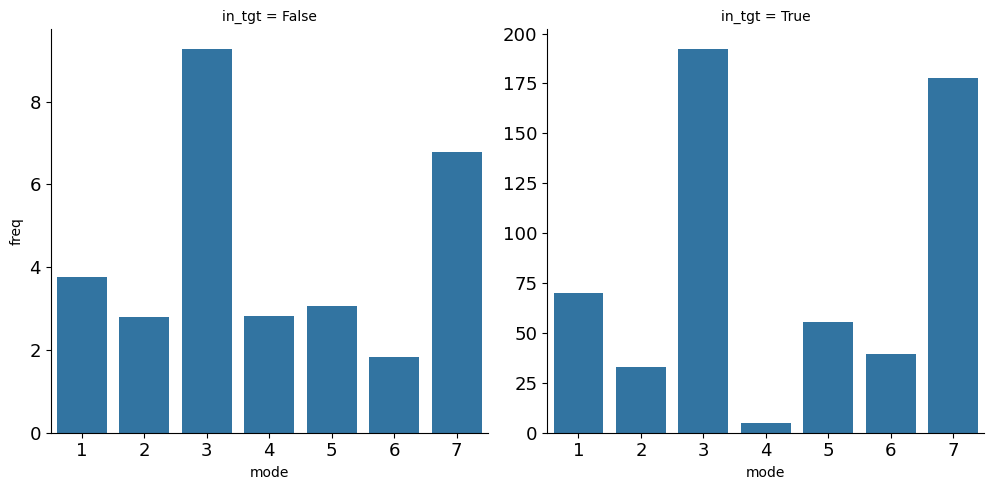

In [417]:
# sns.barplot(pred_mode_df, x="mode", y="freq", hue="in_tgt")

sns.catplot(
    data=pred_mode_df, x="mode", y="freq",
    col="in_tgt", 
    # hue="class", palette=pal,
    kind="bar", sharey=False, errorbar=None,
)

C:\Users\hong\AppData\Local\Temp\ipykernel_10880\648707482.py:7: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(pd.concat([class_3, non_class_3]), x="mode", y="proportion", hue="type", palette=pal)


<Axes: xlabel='mode', ylabel='proportion'>

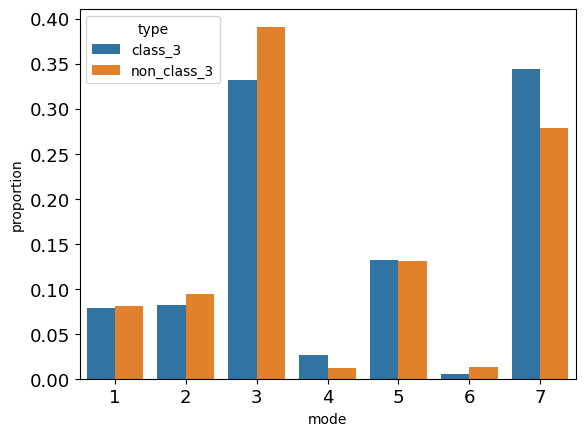

In [773]:
class_3 = explore_mode.loc[explore_mode["class"]==3]['mode'].value_counts(normalize=True).to_frame("proportion")
non_class_3 = explore_mode.loc[explore_mode["class"]!=3]['mode'].value_counts(normalize=True).to_frame("proportion")

class_3["type"] = "class_3"
non_class_3["type"] = "non_class_3"
class_3
sns.barplot(pd.concat([class_3, non_class_3]), x="mode", y="proportion", hue="type", palette=pal)

# walk to car

C:\Users\hong\AppData\Local\Temp\ipykernel_10880\3245638465.py:10: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(explore_mode_counts, x="class", y="percentage", hue="mode", palette=pal)


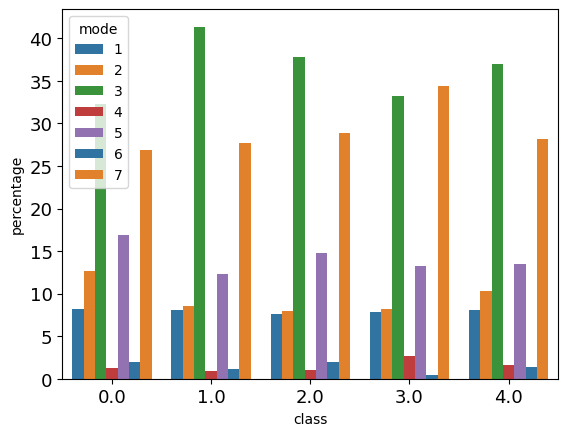

In [764]:
explore_mode = pred_mode_df.loc[~pred_mode_df["in_tgt"]]

explore_mode_counts = (explore_mode.groupby(['class'])['mode']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

# explore_mode.groupby(["class", "mode"])["freq"].sum().groupby("class").sum()
sns.barplot(explore_mode_counts, x="class", y="percentage", hue="mode", palette=pal)

plt.show()

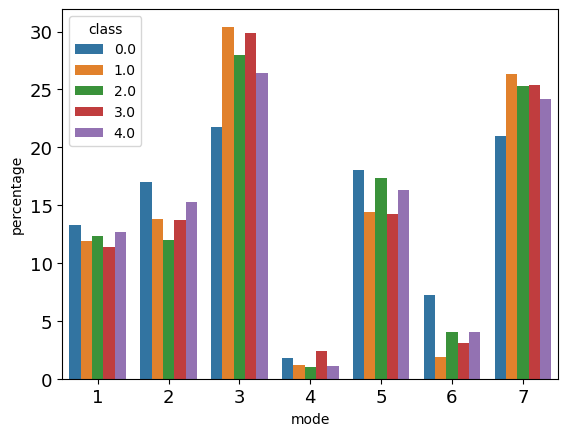

In [756]:
return_mode = pred_mode_df.loc[pred_mode_df["in_tgt"]]

return_mode_counts = (return_mode.groupby(['class'])['mode']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

# explore_mode.groupby(["class", "mode"])["freq"].sum().groupby("class").sum()
sns.barplot(return_mode_counts, x="mode", y="percentage", hue="class", palette=pal)

plt.show()

In [759]:
return_mode_counts["type"] = "return"
explore_mode_counts["type"] = "explore"

C:\Users\hong\AppData\Local\Temp\ipykernel_10880\592199554.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(pd.concat([return_mode_counts,explore_mode_counts ]), x="mode", y="percentage", hue="type", palette=pal)


<Axes: xlabel='mode', ylabel='percentage'>

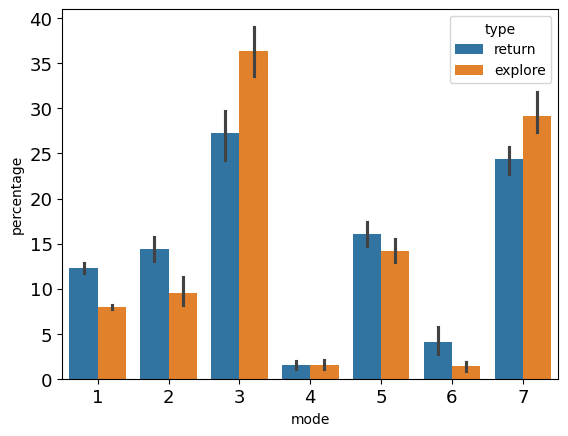

In [761]:
sns.barplot(pd.concat([return_mode_counts,explore_mode_counts ]), x="mode", y="percentage", hue="type", palette=pal)

,loc,mode,class,center_dist,dur,jump,freq,jump_median,in_tgt,freq_norm
4,4,2,3.0,0.171170,132.248993,196005.228965,1,196005.228965,False,0.000153
5,6,3,3.0,0.454628,102.763247,141210.368728,4,143025.543959,False,0.000613
6,14,3,3.0,0.171170,99.510002,174421.651439,1,174421.651439,False,0.000153
7,21,7,1.0,0.096855,32.613998,130831.538257,1,130831.538257,False,0.000018
8,24,1,1.0,0.125719,232.179996,104353.030902,2,104353.030902,False,0.000035
...,...,...,...,...,...,...,...,...,...,...
30707,28723,3,1.0,0.081100,74.402000,25798.928781,1,25798.928781,False,0.000018
30708,28724,3,1.0,0.101951,55.010501,99485.226281,2,99485.226281,False,0.000035
30709,28726,3,1.0,0.205630,778.743572,152029.581460,42,165850.503984,False,0.000742
30710,28730,3,1.0,0.048506,87.940165,53101.498184,6,51521.663110,False,0.000106


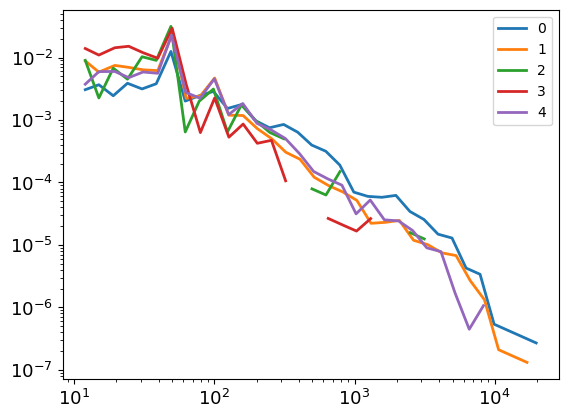

In [140]:
for i in range(5):
    powerlaw.plot_pdf(tgt_final_df.loc[tgt_final_df["class"]==i, "freq"], label=f"{i}", linewidth=2)

plt.legend()

In [774]:
pred_info_df["min_bin_15"] = pred_info_df["time"] // 15
pred_time_df = pred_info_df.groupby(["class", "min_bin_15"], as_index=False).size()

tgt_info_df["min_bin_15"] = tgt_info_df["time"] // 15
tgt_time_df = tgt_info_df.groupby(["class", "min_bin_15"], as_index=False).size()

In [775]:
tgt_time_df

,class,min_bin_15,size
0,0,0.0,1079
1,0,1.0,366
2,0,2.0,262
3,0,3.0,407
4,0,4.0,338
...,...,...,...
428,4,91.0,758
429,4,92.0,781
430,4,93.0,252
431,4,94.0,318


In [778]:
tgt_time_df.groupby("class")["size"].sum()

class
0    556545
1    690446
2     19325
3     22991
4    443515
Name: size, dtype: int64

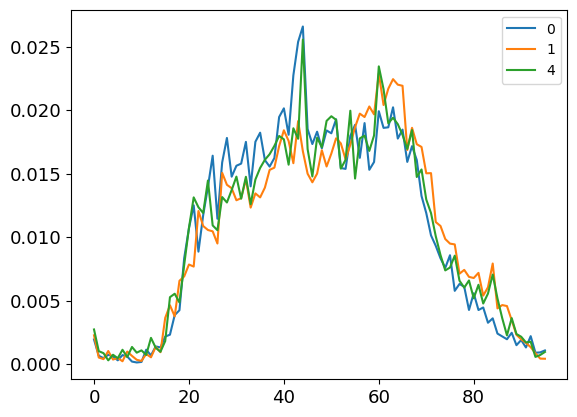

In [806]:
class_ls = []

for i in range(5):

    temp = tgt_time_df.loc[tgt_time_df["class"]==i][["size", "min_bin_15"]]
    temp["size"] = temp["size"]/temp["size"].sum()
    class_ls.append(temp)


for i, class_arr in enumerate(class_ls):
    if i == 2 or i == 3:
        continue
    plt.plot(class_arr.min_bin_15, class_arr["size"], label=f"{i}")

plt.legend()
plt.show()

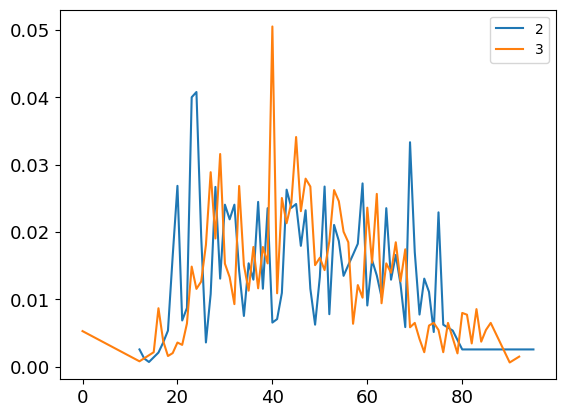

In [808]:
for i, class_arr in enumerate(class_ls):
    if i != 2 and i != 3:
        continue
    plt.plot(class_arr.min_bin_15, class_arr["size"], label=f"{i}")

plt.legend()
plt.show()

In [111]:
true_visit_counts = np.zeros(28741)
pred_visit_counts = np.zeros(28741)

for ls in true_ls:
    unique, counts = np.unique(ls, return_counts=True)
    for num, freq in zip(unique, counts):
        true_visit_counts[num-1] +=freq

for ls in predict_ls[0]:
    unique, counts = np.unique(ls, return_counts=True)
    for num, freq in zip(unique, counts):
        pred_visit_counts[num-1] +=freq

In [112]:
true_visit_counts, pred_visit_counts

(array([  0.,  36.,   0., ...,   0.,   0., 150.]),
 array([ 0., 13.,  0., ...,  0.,  0.,  0.]))

In [113]:
all_locs["true_count"] = true_visit_counts
all_locs["pred_count"] = pred_visit_counts

In [121]:
all_locs.groupby("class")["true_count"].mean(), all_locs.groupby("class")["pred_count"].mean()

(class
 0    396.682110
 1     46.323113
 2     24.712276
 3      5.661413
 4     58.434124
 Name: true_count, dtype: float64,
 class
 0    409.371347
 1     49.554780
 2     22.046036
 3      4.951244
 4     61.125296
 Name: pred_count, dtype: float64)